<a href="https://colab.research.google.com/github/aren4/Liver_Tumors/blob/main/Tommy_Rads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit_survival

In [2]:
!pip install lifelines

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.linear_model import CoxPHSurvivalAnalysis
from lifelines import CoxPHFitter, KaplanMeierFitter
from sksurv.nonparametric import kaplan_meier_estimator
from tqdm import tqdm
import re

pd.set_option('display.max_columns', None)

df = pd.read_csv('/content/drive/MyDrive/Tommy Rads/Secondary_Analysis.csv', index_col=False, encoding='latin1')

In [4]:
numeric_cols = df.select_dtypes(include=np.number).columns

# Apply the mask to only the numeric columns
df[numeric_cols] = df[numeric_cols].mask(df[numeric_cols] < 0)

print(df)

    Date Ablation  Last Name        ID # First Name        DOB Sex   Race  \
0      12/22/2022     HORNER  8471498543       JOSH  9/26/1972   M  White   
1      12/19/2022     TAYLOR  8474225240     DONALD  9/22/1949   M  Black   
2       9/28/2022  DOUGHERTY  8443623400     ANDREA  3/20/1981   F  White   
3        8/3/2022       TORO  8464386796      CAROL  8/12/1959   F  White   
4       7/19/2022     KOFFEL  1002771556    MICHELE  9/20/1983   F  White   
..            ...        ...         ...        ...        ...  ..    ...   
132     4/16/2015    ANSELMO   441880150     JOSEPH  7/26/1945   M  White   
133     2/17/2015     RUDMAN   442666962  CATHERINE   3/9/1964   F  White   
134     2/12/2015    MCMAHON   443552039    MICHAEL  3/21/1966   M  White   
135     1/28/2015  WILKINSON    59872176      DEBRA  12/2/1963   F  White   
136      1/6/2015      EWING     6698286       ANNE   2/8/1938   F  White   

       Ethnicity  type of cancer Date Dx Different Primary  \
0    NotHispa

In [5]:
# Replace '-' with NaN
#df.replace('-', np.nan, inplace=True)

# Helper function to flag unexpected values
def flag_unexpected(series, expected_type, allowed_values=None, pattern=None):
    flagged = []
    for idx, val in series.items():
        if pd.isna(val):
            continue
        if allowed_values is not None and val not in allowed_values:
            flagged.append((idx, val))
        elif expected_type == 'numeric':
            try:
                float(str(val).replace('A','')) # '12A' becomes '12'
            except:
                flagged.append((idx, val))
        elif expected_type == 'binary':
            if str(val) not in ['0', '1']:
                flagged.append((idx, val))
        elif pattern is not None:
            if not re.match(pattern, str(val)):
                flagged.append((idx, val))
    return flagged

# Cleaning report dictionary
cleaning_report = {}

# Sex: Recode to binary Sex: Male
df['Sex'] = df['Sex'].str.strip().str.upper().replace({'MALE': 'M', 'FEMALE': 'F'})
sex_binary = df['Sex'].map({'M': 1, 'F': 0})
df['Sex: Male'] = sex_binary
cleaning_report['Sex'] = flag_unexpected(df['Sex'], 'str', allowed_values=['M', 'F'])

# Race
allowed_races = ['White', 'Black', 'Asian', 'Other', 'Unknown']
df['Race'] = df['Race'].astype(str).str.strip().str.title()
cleaning_report['Race'] = flag_unexpected(df['Race'], 'str', allowed_values=allowed_races)

# Ethnicity
allowed_ethnicities = ['Hispanic', 'Nothispanic', 'Unknown']
df['Ethnicity'] = df['Ethnicity'].astype(str).str.strip().str.title()
cleaning_report['Ethnicity'] = flag_unexpected(df['Ethnicity'], 'str', allowed_values=allowed_ethnicities)

# Type of cancer
df['type of cancer'] = df['type of cancer'].astype(str).str.strip().str.lower()

# Age
df['Age Date Dx Liver Cancer'] = pd.to_numeric(df['Age Date Dx Liver Cancer'], errors='coerce')
cleaning_report['Age Date Dx Liver Cancer'] = flag_unexpected(df['Age Date Dx Liver Cancer'], 'numeric')

# CAT HCV
allowed_hcv = [0, 2]
df['CAT HCV (2-SVR, 1 for chronic/present, 3 HBV 4 HAV)'] = pd.to_numeric(
    df['CAT HCV (2-SVR, 1 for chronic/present, 3 HBV 4 HAV)'], errors='coerce'
)
cleaning_report['CAT HCV'] = flag_unexpected(
    df['CAT HCV (2-SVR, 1 for chronic/present, 3 HBV 4 HAV)'], 'numeric', allowed_values=allowed_hcv)

# Define a mapping of scores to integers
score_mapping = {
    '5': 1,
    '6': 2,
    '7': 3,
    '8': 4,
    '9': 5,
    '10': 6,
    '11': 7,
    '12': 8,
    '13': 9,
    '14': 10,
    '15': 11
}

# Function to extract the relevant score from the string, while handling NaN values
def extract_score(text):
    if isinstance(text, str):  # Check if the entry is a string
        for score in score_mapping:
            if re.search(score, text):
                return score
    return None  # Return None if NaN or no match is found

# Apply the function to extract the score and then map it to the integer value
df['SCALAR CPT Score (Extracted)'] = df['CPT Score'].apply(extract_score)
df['SCALAR CPT Score (Recode)'] = df['SCALAR CPT Score (Extracted)'].map(score_mapping)

# Binary columns
binary_cols = ['EtOH', 'NASH', 'Ascites', 'Encephalopathy', 'First CEA Elevated',
               'Unilobar (0), Bilobar (1)', 'Bx during ablation (0-no, 1-yes, 2-NGS)']
for col in binary_cols:
    allowed = ['0', '1'] if 'Bx during ablation' not in col else ['0', '1', '2']
    df[col] = df[col].astype(str).str.strip()
    df[col].replace('', np.nan, inplace=True)
    cleaning_report[col] = flag_unexpected(df[col], 'binary', allowed_values=allowed)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Scalar numeric columns
scalar_cols = ['WBC', 'Hgb', 'Plt', 'Na', 'Cr', 'Albumin', 'Tbili', 'INR', 'CEA',
               '#tumors to ablate', 'Longest Diameter Largest lesion (mm)',
               'Sum Longest Diameters', 'PS', 'Time to recur', 'SCALAR CPT Score (Recode)', 'First ablation total energy']
for col in scalar_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    cleaning_report[col] = flag_unexpected(df[col], 'numeric')

# Segment Largest Index Lesion (integer, sometimes with an 'A' suffix)
def clean_segment(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, str) and x.endswith('A'):
        x = x[:-1]
    try:
        return int(x)
    except:
        return np.nan
df['Segment Largest Index Lesion'] = df['Segment Largest Index Lesion'].apply(clean_segment)
cleaning_report['Segment Largest Index Lesion'] = flag_unexpected(df['Segment Largest Index Lesion'], 'numeric')


/tmp/ipython-input-4106648609.py:92: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace('', np.nan, inplace=True)
/tmp/ipython-input-4106648609.py:92: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using '

In [6]:
df.head()

,Date Ablation,Last Name,ID #,First Name,DOB,Sex,Race,Ethnicity,type of cancer,Date Dx Different Primary,Date Dx Liver Cancer,Age Date Dx Liver Cancer,"CAT HCV (2-SVR, 1 for chronic/present, 3 HBV 4 HAV)",EtOH,NASH,Ascites,Encephalopathy,WBC,Hgb,Plt,Na,Cr,Albumin,Tbili,INR,AFP,IU/ng,CEA,First CEA Elevated,#tumors to ablate,Longest Diameter Largest lesion (mm),Sum Longest Diameters,Segment Largest Index Lesion,"Unilobar (0), Bilobar (1)","Bx during ablation (0-no, 1-yes, 2-NGS)",BCLC Stage,Native Na-MELD,CPT Score,PS,"Liver Treatment prior to initial ablation (0-none, 1-TACE, 2-TARE, 3-EBRT, 4-Systemic Therapy, 5-resection, 6-combined/other)",First ablation parameters,First ablation probe,First ablation total energy,Date Post-Ablation Imaging,"Recur (0-no, 1-yes)",Date of Imaging Recurrence,Time to recur,"Recurrence Local (0-no, 1-yes)",Recurrence EHD,Site of EHD,Description hepatic Recurrence,Size recurrent disease liver (mm),Treatment recurrence,Additional Details of Initial Repeat Tx/Rp Ablation parameters,Repeat ablation probe,Repeat ablation total energy,Ascites2,Encephalopathy2,WBC2,Hgb5,Plt6,Na7,Cr8,Albumin2,Tbili2,INR11,AFP12,AFP unit,CEA13,Second CEA Elevated,# tumors to ablate,Longest Diameter Largest lesion,Sum Longest Diameters15,Segment of Largest Index Lesion16,"Unilobar (0), Bilobar (1)17",BCLC,Native Na-MELD18,CPT Score19,PS20,"Bx recurrence (0-no,1-yes,2-NGS)",Date of Repeat Tx,Date Imaging after repeat treatment,Results follow-up Imaging at target lesion,Non-target results,Date of first progression from Repeat,"Progression Local(0-no,1-yes)",TTP after repeat treatment,Date of last liver imaging,Response at last liver imaging,Non-target response at last imaging,Date last follow up,Days between follow up and first ablation,"Status at last follow up (0-alive, 1-dead, 2-LTFU)",Other notes,Time to recurrence post ablation,Sex: Male,SCALAR CPT Score (Extracted),SCALAR CPT Score (Recode)
0,12/22/2022,HORNER,8471498543,JOSH,9/26/1972,M,White,Nothispanic,colon,11/18/2021,11/2/2021,49,0,0,0,0,0,8.74,16.5,174.0,141.0,0.82,4.4,0.5,0.9,-,NaN,7.3,1.0,1,30,30,6.0,0,0,-,-,-,1.0,"4, 5",20cm Neuwave mp,PR20,650,1/18/2023,0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,NaN,#VALUE!,4/4/2023,CR,NaN,7/7/2023,197,0,"MWA was for recurrence, lung metastases but no...",NaN,1,None,NaN
1,12/19/2022,TAYLOR,8474225240,DONALD,9/22/1949,M,Black,Unknown,colon,9/8/2021,10/26/2022,73,0,0,0,0,0,11.50,13.5,151.0,141.0,0.81,3.8,0.9,1.0,-,NaN,4.0,0.0,1,19,19,4.0,0,0,NaN,-,-,NaN,4,PR 65Wx10m,PR15,650,2/14/2023,0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,NaN,#VALUE!,2/14/2023,CR,NaN,7/17/2023,210,0,Only Continuity of Care notes available (VA). ...,NaN,1,None,NaN
2,9/28/2022,DOUGHERTY,8443623400,ANDREA,3/20/1981,F,White,Nothispanic,leiomyosarcoma,11/13/2017,7/15/2022,41,0,0,0,0,0,3.80,13.0,211.0,136.0,0.94,4.6,0.7,1.0,-,NaN,2.4,NaN,1,22,22,2.0,1,1,-,-,-,0.0,"4,5",2 PR 65Wx5m,PR15,650,10/19/2022,1,10/21/2022,23.0,0.0,0.0,NaN,Enhancing diffusion restricting neoplasm in th...,12x9,0.0,Pr 65Wx5m,PR15,325.0,0.0,0.0,4.0,11.0,264.0,138.0,1.0,4.0,1.0,1,-,NaN,-,NaN,1.0,12.0,12.0,2,0.0,-,-,-,0.0,0.0,12/29/2022,1/31/2023,CR,PD,1/31/2023,0.0,33,8/28/2023,PD,PD,8/9/2023,315,1,"On lanreotide, DOTATATE, pazopanib",23.0,0,None,NaN
3,8/3/2022,TORO,8464386796,CAROL,8/12/1959,F,White,Nothispanic,lung,10/16/2018,1/6/2022,62,0,0,0,0,0,5.00,9.5,248.0,139.0,1.03,3.7,0.4,0.9,-,NaN,NaN,NaN,1,23,23,5.0,0,0,-,-,-,1.0,"6 (Bland embo), 4",15cm Neuwave mp,PR15,650,9/20/2022,1,9/20/2022,48.0,0.0,1.0,"Lung, Brain",post-ablation changes in the treated lesion. ...,Segment 7 (25/25) 1.5 x 1.5 cm. Inferior segme...,2.0,y90,NaN,NaN,0.0,0.0,10.0,10.0,136.0,139.0,1.0,4.0,0.0,1,-,NaN,-,NaN,3.0,16.0,44.0,7,1.0,-,-,-,1.0,0.0,11/16/2022,12/12/2022,PR,PD,12/12/2022,0.0,2

In [7]:
# Liver Treatment prior to initial ablation
treatment_map = {
    '1': 'TACE',
    '2': 'TARE',
    '3': 'EBRT',
    '4': 'Systemic Therapy',
    '5': 'Resection',
    '6': 'Combined/Other'
}
def treatment_flags(cell):
    flags = {name: 0 for name in treatment_map.values()}
    if pd.isna(cell):
        return pd.Series(flags)
    items = re.findall(r'\d', str(cell))
    for item in items:
        if item in treatment_map:
            flags[treatment_map[item]] = 1
    return pd.Series(flags)
treatments = df['Liver Treatment prior to initial ablation (0-none, 1-TACE, 2-TARE, 3-EBRT, 4-Systemic Therapy, 5-resection, 6-combined/other)'].apply(treatment_flags)
df = pd.concat([df, treatments], axis=1)
df.drop(columns=['Liver Treatment prior to initial ablation (0-none, 1-TACE, 2-TARE, 3-EBRT, 4-Systemic Therapy, 5-resection, 6-combined/other)'], inplace=True)

# Recur (dependent)
df['Recur (0-no, 1-yes)'] = pd.to_numeric(df['Recur (0-no, 1-yes)'], errors='coerce')
cleaning_report['Recur (0-no, 1-yes)'] = flag_unexpected(df['Recur (0-no, 1-yes)'], 'binary', allowed_values=['0', '1'])

# Gather cleaning report and summarize any flagged values
flagged_summary = {col: flagged for col, flagged in cleaning_report.items() if flagged}
flagged_summary  # Show all columns with flagged/unexpected values and what those are


{'First CEA Elevated': [(0, '1.0'),
  (1, '0.0'),
  (2, 'nan'),
  (3, 'nan'),
  (4, 'nan'),
  (5, '0.0'),
  (6, '1.0'),
  (7, '1.0'),
  (8, '1.0'),
  (9, '0.0'),
  (10, 'nan'),
  (11, 'nan'),
  (12, '0.0'),
  (13, 'nan'),
  (14, '1.0'),
  (15, 'nan'),
  (16, '1.0'),
  (17, 'nan'),
  (18, 'nan'),
  (19, 'nan'),
  (20, '0.0'),
  (21, 'nan'),
  (22, 'nan'),
  (23, '0.0'),
  (24, 'nan'),
  (25, 'nan'),
  (26, '0.0'),
  (27, '0.0'),
  (28, '0.0'),
  (29, '1.0'),
  (30, '0.0'),
  (31, 'nan'),
  (32, 'nan'),
  (33, '1.0'),
  (34, '0.0'),
  (35, '1.0'),
  (36, 'nan'),
  (37, '0.0'),
  (38, '1.0'),
  (39, 'nan'),
  (40, 'nan'),
  (41, '1.0'),
  (42, 'nan'),
  (43, 'nan'),
  (44, 'nan'),
  (45, 'nan'),
  (46, 'nan'),
  (47, 'nan'),
  (48, '0.0'),
  (49, 'nan'),
  (50, 'nan'),
  (51, 'nan'),
  (52, 'nan'),
  (53, '1.0'),
  (54, '0.0'),
  (55, 'nan'),
  (56, 'nan'),
  (57, 'nan'),
  (58, '1.0'),
  (59, '1.0'),
  (60, 'nan'),
  (61, 'nan'),
  (62, 'nan'),
  (63, '1.0'),
  (64, 'nan'),
  (65, '1.0')

In [8]:
df.head()

,Date Ablation,Last Name,ID #,First Name,DOB,Sex,Race,Ethnicity,type of cancer,Date Dx Different Primary,Date Dx Liver Cancer,Age Date Dx Liver Cancer,"CAT HCV (2-SVR, 1 for chronic/present, 3 HBV 4 HAV)",EtOH,NASH,Ascites,Encephalopathy,WBC,Hgb,Plt,Na,Cr,Albumin,Tbili,INR,AFP,IU/ng,CEA,First CEA Elevated,#tumors to ablate,Longest Diameter Largest lesion (mm),Sum Longest Diameters,Segment Largest Index Lesion,"Unilobar (0), Bilobar (1)","Bx during ablation (0-no, 1-yes, 2-NGS)",BCLC Stage,Native Na-MELD,CPT Score,PS,First ablation parameters,First ablation probe,First ablation total energy,Date Post-Ablation Imaging,"Recur (0-no, 1-yes)",Date of Imaging Recurrence,Time to recur,"Recurrence Local (0-no, 1-yes)",Recurrence EHD,Site of EHD,Description hepatic Recurrence,Size recurrent disease liver (mm),Treatment recurrence,Additional Details of Initial Repeat Tx/Rp Ablation parameters,Repeat ablation probe,Repeat ablation total energy,Ascites2,Encephalopathy2,WBC2,Hgb5,Plt6,Na7,Cr8,Albumin2,Tbili2,INR11,AFP12,AFP unit,CEA13,Second CEA Elevated,# tumors to ablate,Longest Diameter Largest lesion,Sum Longest Diameters15,Segment of Largest Index Lesion16,"Unilobar (0), Bilobar (1)17",BCLC,Native Na-MELD18,CPT Score19,PS20,"Bx recurrence (0-no,1-yes,2-NGS)",Date of Repeat Tx,Date Imaging after repeat treatment,Results follow-up Imaging at target lesion,Non-target results,Date of first progression from Repeat,"Progression Local(0-no,1-yes)",TTP after repeat treatment,Date of last liver imaging,Response at last liver imaging,Non-target response at last imaging,Date last follow up,Days between follow up and first ablation,"Status at last follow up (0-alive, 1-dead, 2-LTFU)",Other notes,Time to recurrence post ablation,Sex: Male,SCALAR CPT Score (Extracted),SCALAR CPT Score (Recode),TACE,TARE,EBRT,Systemic Therapy,Resection,Combined/Other
0,12/22/2022,HORNER,8471498543,JOSH,9/26/1972,M,White,Nothispanic,colon,11/18/2021,11/2/2021,49,0,0,0,0,0,8.74,16.5,174.0,141.0,0.82,4.4,0.5,0.9,-,NaN,7.3,1.0,1,30,30,6.0,0,0,-,-,-,1.0,20cm Neuwave mp,PR20,650,1/18/2023,0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,NaN,#VALUE!,4/4/2023,CR,NaN,7/7/2023,197,0,"MWA was for recurrence, lung metastases but no...",NaN,1,None,NaN,0,0,0,1,1,0
1,12/19/2022,TAYLOR,8474225240,DONALD,9/22/1949,M,Black,Unknown,colon,9/8/2021,10/26/2022,73,0,0,0,0,0,11.50,13.5,151.0,141.0,0.81,3.8,0.9,1.0,-,NaN,4.0,0.0,1,19,19,4.0,0,0,NaN,-,-,NaN,PR 65Wx10m,PR15,650,2/14/2023,0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,NaN,#VALUE!,2/14/2023,CR,NaN,7/17/2023,210,0,Only Continuity of Care notes available (VA). ...,NaN,1,None,NaN,0,0,0,1,0,0
2,9/28/2022,DOUGHERTY,8443623400,ANDREA,3/20/1981,F,White,Nothispanic,leiomyosarcoma,11/13/2017,7/15/2022,41,0,0,0,0,0,3.80,13.0,211.0,136.0,0.94,4.6,0.7,1.0,-,NaN,2.4,NaN,1,22,22,2.0,1,1,-,-,-,0.0,2 PR 65Wx5m,PR15,650,10/19/2022,1,10/21/2022,23.0,0.0,0.0,NaN,Enhancing diffusion restricting neoplasm in th...,12x9,0.0,Pr 65Wx5m,PR15,325.0,0.0,0.0,4.0,11.0,264.0,138.0,1.0,4.0,1.0,1,-,NaN,-,NaN,1.0,12.0,12.0,2,0.0,-,-,-,0.0,0.0,12/29/2022,1/31/2023,CR,PD,1/31/2023,0.0,33,8/28/2023,PD,PD,8/9/2023,315,1,"On lanreotide, DOTATATE, pazopanib",23.0,0,None,NaN,0,0,0,1,1,0
3,8/3/2022,TORO,8464386796,CAROL,8/12/1959,F,White,Nothispanic,lung,10/16/2018,1/6/2022,62,0,0,0,0,0,5.00,9.5,248.0,139.0,1.03,3.7,0.4,0.9,-,NaN,NaN,NaN,1,23,23,5.0,0,0,-,-,-,1.0,15cm Neuwave mp,PR15,650,9/20/2022,1,9/20/2022,48.0,0.0,1.0,"Lung, Brain",post-ablation changes in the treated lesion. ...,Segment 7 (25/25) 1.5 x 1.5 cm. Inferior segme...,2.0,y90,NaN,NaN,0.0,0.0,10.0,10.0,136.0,139.0,1.0,4.0,0.0,1,-,NaN,-,NaN,3.0,16.0,44.0,7,1.0,-,-,-,1.0,0.0,11/16/2022,12/12/2022,PR,PD,12/12/2022,0.0,26,3/23/2023,SD,SD,3/21/2023,230,1,NaN,48.0,0,None,NaN,0,0,0,1,0,1
4,7/

In [9]:
# First CEA Elevated: Recode to binary integers
df['First CEA Elevated'] = df['First CEA Elevated'].replace({'1.0': 1, '0.0': 0}).astype(float)
# (Leave np.nan for missing)

# Bx during ablation: Create one-hot columns for Yes (1) and NGS (2)
df['Bx during ablation: Yes'] = (df['Bx during ablation (0-no, 1-yes, 2-NGS)'] == 1).astype(int)
df['Bx during ablation: NGS'] = (df['Bx during ablation (0-no, 1-yes, 2-NGS)'] == 2).astype(int)

df['First ablation probe: PR15'] = (df['First ablation probe'] == 'PR15').astype(int)
df['First ablation probe: PR15'] = (df['First ablation probe'] == 'PR').astype(int)
df['First ablation probe: PR20'] = (df['First ablation probe'] == 'PR20').astype(int)
df['First ablation probe: LK'] = (df['First ablation probe'] == 'LK').astype(int)
df['First ablation probe: Solaris'] = (df['First ablation probe'] == 'Solaris').astype(int)

# Show the first 10 rows of the cleaned dataframe for relevant columns
df[['First CEA Elevated', 'Bx during ablation (0-no, 1-yes, 2-NGS)',
    'Bx during ablation: Yes', 'Bx during ablation: NGS', 'First ablation probe: PR15', 'First ablation probe: PR20', 'First ablation probe: LK', 'First ablation probe: Solaris']].head(10)


,First CEA Elevated,"Bx during ablation (0-no, 1-yes, 2-NGS)",Bx during ablation: Yes,Bx during ablation: NGS,First ablation probe: PR15,First ablation probe: PR20,First ablation probe: LK,First ablation probe: Solaris
0,1.0,0,0,0,0,1,0,0
1,0.0,0,0,0,0,0,0,0
2,NaN,1,1,0,0,0,0,0
3,NaN,0,0,0,0,0,0,0
4,NaN,0,0,0,0,0,0,0
5,0.0,0,0,0,0,0,1,0
6,1.0,0,0,0,0,0,1,0
7,1.0,0,0,0,0,0,0,0
8,1.0,0,0,0,0,0,0,0
9,0.0,0,0,0,0,0,1,0


In [10]:
# Define columns
scalar_cols = [
    'Age Date Dx Liver Cancer', 'WBC', 'Hgb', 'Plt', 'Na', 'Cr', 'Albumin', 'Tbili', 'INR', 'First ablation total energy',
    'CEA', '#tumors to ablate', 'Longest Diameter Largest lesion (mm)', 'Sum Longest Diameters', 'PS', 'SCALAR CPT Score (Recode)'
]
binary_cols = [
    'Sex: Male', 'EtOH', 'NASH', 'Ascites', 'Encephalopathy', 'First CEA Elevated',
    'Unilobar (0), Bilobar (1)', 'Bx during ablation: Yes', 'Bx during ablation: NGS', 'First ablation probe: PR15',
    'First ablation probe: PR20', 'First ablation probe: LK', 'First ablation probe: Solaris', 'Recur (0-no, 1-yes)',
    'TACE',	'TARE',	'EBRT',	'Systemic Therapy',	'Resection',	'Combined/Other'
]
categorical_cols = [
    'Race', 'Ethnicity', 'type of cancer', 'CAT HCV (2-SVR, 1 for chronic/present, 3 HBV 4 HAV)'
]

# Check scalar columns: should be numeric or NaN
scalar_issues = {}
for col in scalar_cols:
    not_scalar = df[~df[col].isna() & ~df[col].apply(lambda x: isinstance(x, (int, float)))][col]
    if not not_scalar.empty:
        scalar_issues[col] = not_scalar.unique().tolist()

# Check binary columns: should be 0, 1, or NaN
binary_issues = {}
for col in binary_cols:
    vals = set(df[col].dropna().unique())
    if not vals.issubset({0, 1}):
        binary_issues[col] = vals - {0, 1}

# Check categorical columns: show all unique values
categorical_uniques = {col: df[col].dropna().unique().tolist() for col in categorical_cols}

(scalar_issues, binary_issues, categorical_uniques)

df.to_csv("Secondary_Tumors_Cleaned.csv", index=False)
!cp Secondary_Tumors_Cleaned.csv "/content/drive/My Drive/Tommy Rads/"

In [11]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Exclude dependent variable from imputation
impute_cols = [col for col in (scalar_cols + binary_cols) if col != 'Recur (0-no, 1-yes)']

# Prepare input for imputation
impute_df = df[impute_cols]

# MICE imputation
mice = IterativeImputer(random_state=42, sample_posterior=True, max_iter=20)
imputed_array = mice.fit_transform(impute_df)
imputed_df = pd.DataFrame(imputed_array, columns=impute_cols, index=impute_df.index)

# Restore binary columns as integer 0/1
for col in binary_cols:
    if col in imputed_df.columns:
        imputed_df[col] = imputed_df[col].round().astype(int)

# Add back categorical and dependent columns, in original order
final_df = pd.concat(
    [imputed_df, df[categorical_cols + ['type of cancer', 'Recur (0-no, 1-yes)']]],
    axis=1
)

# Show head and check remaining NaNs
(final_df.head(), final_df.isna().sum())

(   Age Date Dx Liver Cancer    WBC   Hgb    Plt     Na    Cr  Albumin  Tbili  \
 0                      49.0   8.74  16.5  174.0  141.0  0.82      4.4    0.5   
 1                      73.0  11.50  13.5  151.0  141.0  0.81      3.8    0.9   
 2                      41.0   3.80  13.0  211.0  136.0  0.94      4.6    0.7   
 3                      62.0   5.00   9.5  248.0  139.0  1.03      3.7    0.4   
 4                      37.0   4.40  12.9  286.0  139.0  0.80      4.4    0.4   
 
    INR  First ablation total energy         CEA  #tumors to ablate  \
 0  0.9                        650.0    7.300000                1.0   
 1  1.0                        650.0    4.000000                1.0   
 2  1.0                        650.0    2.400000                1.0   
 3  0.9                        650.0  335.545818                1.0   
 4  1.1                       1300.0    0.000000                2.0   
 
    Longest Diameter Largest lesion (mm)  Sum Longest Diameters        PS  \
 0     

In [12]:
# Drop duplicate columns, if any (from prior concatenation)
final_df = final_df.loc[:,~final_df.columns.duplicated()]

# Define categorical columns
categorical_cols = ['Race', 'Ethnicity', 'type of cancer', 'CAT HCV (2-SVR, 1 for chronic/present, 3 HBV 4 HAV)']

# One-hot encode, drop first to avoid collinearity
final_encoded = pd.get_dummies(final_df, columns=categorical_cols, drop_first=True)

# Show shape and column sample
(final_encoded.shape, final_encoded.columns.tolist()[:12])


((137, 56),
 ['Age Date Dx Liver Cancer',
  'WBC',
  'Hgb',
  'Plt',
  'Na',
  'Cr',
  'Albumin',
  'Tbili',
  'INR',
  'First ablation total energy',
  'CEA',
  '#tumors to ablate'])

In [13]:
final_encoded.head()

,Age Date Dx Liver Cancer,WBC,Hgb,Plt,Na,Cr,Albumin,Tbili,INR,First ablation total energy,CEA,#tumors to ablate,Longest Diameter Largest lesion (mm),Sum Longest Diameters,PS,SCALAR CPT Score (Recode),Sex: Male,EtOH,NASH,Ascites,Encephalopathy,First CEA Elevated,"Unilobar (0), Bilobar (1)",Bx during ablation: Yes,Bx during ablation: NGS,First ablation probe: PR15,First ablation probe: PR20,First ablation probe: LK,First ablation probe: Solaris,TACE,TARE,EBRT,Systemic Therapy,Resection,Combined/Other,"Recur (0-no, 1-yes)",Race_Black,Race_Other,Race_White,Ethnicity_Nothispanic,Ethnicity_Unknown,type of cancer_breast,type of cancer_colon,type of cancer_esophageal,type of cancer_gist,type of cancer_leiomyosarcoma,type of cancer_lung,type of cancer_net,type of cancer_ocular,type of cancer_ovarian,type of cancer_pancreas,type of cancer_parathyroid,type of cancer_parotid,type of cancer_renal,type of cancer_urothelial cc,"CAT HCV (2-SVR, 1 for chronic/present, 3 HBV 4 HAV)_2"
0,49.0,8.74,16.5,174.0,141.0,0.82,4.4,0.5,0.9,650.0,7.300000,1.0,30.0,30.0,1.000000,1.741483,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,False,False,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
1,73.0,11.50,13.5,151.0,141.0,0.81,3.8,0.9,1.0,650.0,4.000000,1.0,19.0,19.0,0.145896,1.604989,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
2,41.0,3.80,13.0,211.0,136.0,0.94,4.6,0.7,1.0,650.0,2.400000,1.0,22.0,22.0,0.000000,2.193023,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,1,0,1,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
3,62.0,5.00,9.5,248.0,139.0,1.03,3.7,0.4,0.9,650.0,335.545818,1.0,23.0,23.0,1.000000,1.081831,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
4,37.0,4.40,12.9,286.0,139.0,0.80,4.4,0.4,1.1,1300.0,0.000000,2.0,17.0,32.0,0.000000,0.130632,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False


In [14]:
# Build duration and event columns for Cox model
cox_df = final_encoded.copy()
# Use event: 1 if recurred, 0 if censored
cox_df['event'] = cox_df['Recur (0-no, 1-yes)']

# Duration: 'Time to recur' if event, else 'Days between follow up and first ablation'
# Ensure both are numeric
cox_df['Time to recur'] = pd.to_numeric(df['Time to recur'], errors='coerce')
cox_df['Days between follow up and first ablation'] = pd.to_numeric(df['Days between follow up and first ablation'], errors='coerce')

cox_df['duration'] = np.where(
    cox_df['event'] == 1,
    cox_df['Time to recur'],
    cox_df['Days between follow up and first ablation']
)

# Drop any rows missing duration or event
cox_df = cox_df.dropna(subset=['duration', 'event'])

# One-hot encode categorical variables (and treatment columns if not binary already)
categorical_cols = [
    'Race', 'Ethnicity', 'type of cancer', 'CAT HCV (2-SVR, 1 for chronic/present, 3 HBV 4 HAV)',
    'TACE', 'TARE', 'EBRT', 'Systemic Therapy', 'Resection', 'Combined/Other'
]
# Only include those that exist (sometimes a treatment might not be present in this subset)
categorical_cols = [col for col in categorical_cols if col in cox_df.columns]

cox_encoded = pd.get_dummies(cox_df, columns=categorical_cols, drop_first=True)

# Drop extra time columns from predictors
for drop_col in ['Time to recur', 'Days between follow up and first ablation', 'Recur (0-no, 1-yes)']:
    if drop_col in cox_encoded.columns:
        cox_encoded = cox_encoded.drop(columns=[drop_col])

# Show ready-for-cox head and shape
cox_encoded[['duration', 'event']].head(), cox_encoded.shape


(   duration  event
 0     197.0      0
 1     210.0      0
 2      23.0      1
 3      48.0      1
 4     284.0      0,
 (136, 57))

In [15]:
# Prepare predictors (X) and outcome (y)
X = cox_encoded.drop(columns=['duration', 'event'])
y = np.array([(bool(e), d) for e, d in zip(cox_encoded['event'], cox_encoded['duration'])],
             dtype=[('event', 'bool'), ('duration', 'float')])

# Remove columns with zero variance
X = pd.DataFrame(X, columns=X.columns)  # ensure DataFrame
nonzero_var_cols = X.std(axis=0) > 0
X_nonzero = X.loc[:, nonzero_var_cols]

# Define threshold for rare variable (e.g., fewer than 10 positive cases)
min_count = 10

# Identify rare one-hot columns (dummy variables)
rare_cols = [col for col in X_nonzero.columns if (X_nonzero[col].sum() < min_count)]

print("Rare columns to drop/collapse:", rare_cols)

# Drop rare columns
X_nonzero_filtered = X_nonzero.drop(columns=rare_cols)
filtered_features = X_nonzero_filtered.columns.tolist()

# Print how many features remain
print(f"Features after dropping rare dummies: {len(filtered_features)} (dropped {len(rare_cols)})")

full_features = X_nonzero_filtered.columns.tolist()

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_nonzero_filtered)

print("Full feature count (after dropping zero-variance):", len(full_features))
print("First 5 features:", full_features[:5])

# Lasso-penalized Cox (L1 only)
model = CoxnetSurvivalAnalysis(l1_ratio=1.0, n_alphas=50, alpha_min_ratio=0.05, max_iter=5000, fit_baseline_model=True)
model.fit(X_scaled, y)

# Get predictions and coefficients for each alpha in the regularization path
scores = []
for i, alpha in enumerate(model.alphas_):
    pred = model.predict(X_scaled, alpha=alpha)
    c_index = concordance_index_censored(
        cox_encoded['event'].astype(bool),
        cox_encoded['duration'],
        pred
    )[0]
    coef = model.coef_[:, i]
    scores.append((alpha, c_index, coef))

# Select best alpha (highest C-index)
best_alpha, best_cindex, best_coef = max(scores, key=lambda t: t[1])
selected = best_coef != 0
selected_features = X_nonzero_filtered.columns[selected]
selected_coefs = best_coef[selected]

# Refit model with best alpha
final_model = CoxnetSurvivalAnalysis(l1_ratio=1.0, alphas=[best_alpha], max_iter=5000)
final_model.fit(X_scaled, y)

print("\nBest alpha (lambda):", best_alpha)
print("Best C-index:", best_cindex)
print("Selected features and coefficients (nonzero):")
for name, val in zip(selected_features, selected_coefs):
    print(f"{name:40s} {val: .3f}")

# Print zero-variance check on standardized data
print((X_scaled.std(axis=0) == 0).sum(), "columns with zero variance after scaling")

# ---- BOOTSTRAP VALIDATION ----

n_bootstraps = 200
selection_counts = np.zeros(len(full_features))
my_bootstrap_alpha = best_alpha / 10

for i in tqdm(range(n_bootstraps)):
    idx = np.random.choice(X_nonzero_filtered.shape[0], size=X_nonzero_filtered.shape[0], replace=True)
    X_boot = X_nonzero_filtered.iloc[idx, :].copy()
    y_boot = y[idx]

    # Guarantee all columns are present, in the same order, even if missing from this resample
    for col in full_features:
        if col not in X_boot:
            X_boot[col] = 0  # fill with zeros

    # Re-order columns to match full_features
    X_boot = X_boot[full_features]

    # Now standardize (do NOT re-fit, just transform)
    X_boot_scaled = scaler.transform(X_boot)

    try:
        boot_model = CoxnetSurvivalAnalysis(l1_ratio=1.0, alphas=[my_bootstrap_alpha], max_iter=5000)
        boot_model.fit(X_boot_scaled, y_boot)
        model_feats = X_boot.columns
        boot_coef = pd.Series(0.0, index=full_features)  # force float for compatibility
        for coef_val, feat in zip(boot_model.coef_[0], model_feats):
            boot_coef[feat] = coef_val
        selection_counts += (boot_coef != 0).values
        print(f"Boot {i}: selected features: {boot_coef[boot_coef != 0].index.tolist()}")
    except Exception as e:
        print(f"Bootstrap {i} failed: {e}")

selection_freq = selection_counts / n_bootstraps
selected_features_df = pd.DataFrame({
    'feature': full_features,
    'selection_freq': selection_freq
}).sort_values('selection_freq', ascending=False)

print("\nFeatures selected in at least one bootstrap:")
print(selected_features_df[selected_features_df.selection_freq > 0])


Rare columns to drop/collapse: ['NASH', 'Encephalopathy', 'Bx during ablation: NGS', 'First ablation probe: PR20', 'Race_Other', 'Ethnicity_Unknown', 'type of cancer_breast', 'type of cancer_esophageal', 'type of cancer_gist', 'type of cancer_leiomyosarcoma', 'type of cancer_ocular', 'type of cancer_ovarian', 'type of cancer_parathyroid', 'type of cancer_parotid', 'type of cancer_renal', 'type of cancer_urothelial cc', 'CAT HCV (2-SVR, 1 for chronic/present, 3 HBV 4 HAV)_2', 'TARE_1', 'EBRT_1']
Features after dropping rare dummies: 33 (dropped 19)
Full feature count (after dropping zero-variance): 33
First 5 features: ['Age Date Dx Liver Cancer', 'WBC', 'Hgb', 'Plt', 'Na']

Best alpha (lambda): 0.010877800189755106
Best C-index: 0.6440349175557711
Selected features and coefficients (nonzero):
Age Date Dx Liver Cancer                  0.102
WBC                                      -0.081
Hgb                                      -0.014
Plt                                       0.193
Na  

  4%|▍         | 8/200 [00:00<00:02, 79.13it/s]

Boot 0: selected features: ['Age Date Dx Liver Cancer']
Boot 1: selected features: ['Age Date Dx Liver Cancer']
Boot 2: selected features: ['Age Date Dx Liver Cancer']
Boot 3: selected features: ['Age Date Dx Liver Cancer']
Boot 4: selected features: ['Age Date Dx Liver Cancer']
Boot 5: selected features: ['Age Date Dx Liver Cancer']
Boot 6: selected features: ['Age Date Dx Liver Cancer']
Boot 7: selected features: ['Age Date Dx Liver Cancer']
Boot 8: selected features: ['Age Date Dx Liver Cancer']
Boot 9: selected features: ['Age Date Dx Liver Cancer']
Boot 10: selected features: ['Age Date Dx Liver Cancer']
Boot 11: selected features: ['Age Date Dx Liver Cancer']
Boot 12: selected features: ['Age Date Dx Liver Cancer']
Boot 13: selected features: ['Age Date Dx Liver Cancer']


 12%|█▏        | 23/200 [00:00<00:02, 59.58it/s]

Boot 14: selected features: ['Age Date Dx Liver Cancer']
Boot 15: selected features: ['Age Date Dx Liver Cancer']
Boot 16: selected features: ['Age Date Dx Liver Cancer']
Boot 17: selected features: ['Age Date Dx Liver Cancer']
Boot 18: selected features: ['Age Date Dx Liver Cancer']
Boot 19: selected features: ['Age Date Dx Liver Cancer']
Boot 20: selected features: ['Age Date Dx Liver Cancer']
Boot 21: selected features: ['Age Date Dx Liver Cancer']
Boot 22: selected features: ['Age Date Dx Liver Cancer']
Boot 23: selected features: ['Age Date Dx Liver Cancer']
Boot 24: selected features: ['Age Date Dx Liver Cancer']


 15%|█▌        | 30/200 [00:00<00:03, 54.52it/s]

Boot 25: selected features: ['Age Date Dx Liver Cancer']
Boot 26: selected features: ['Age Date Dx Liver Cancer']
Boot 27: selected features: ['Age Date Dx Liver Cancer']
Boot 28: selected features: ['Age Date Dx Liver Cancer']
Boot 29: selected features: ['Age Date Dx Liver Cancer']
Boot 30: selected features: ['Age Date Dx Liver Cancer']
Boot 31: selected features: ['Age Date Dx Liver Cancer']


 18%|█▊        | 36/200 [00:00<00:04, 37.86it/s]

Boot 32: selected features: ['Age Date Dx Liver Cancer']
Boot 33: selected features: ['Age Date Dx Liver Cancer']
Boot 34: selected features: ['Age Date Dx Liver Cancer']
Boot 35: selected features: ['Age Date Dx Liver Cancer']
Boot 36: selected features: ['Age Date Dx Liver Cancer']
Boot 37: selected features: ['Age Date Dx Liver Cancer']
Boot 38: selected features: ['Age Date Dx Liver Cancer']


 25%|██▌       | 50/200 [00:01<00:03, 48.70it/s]

Boot 39: selected features: ['Age Date Dx Liver Cancer']
Boot 40: selected features: ['Age Date Dx Liver Cancer']
Boot 41: selected features: ['Age Date Dx Liver Cancer']
Boot 42: selected features: ['Age Date Dx Liver Cancer']
Boot 43: selected features: ['Age Date Dx Liver Cancer']
Boot 44: selected features: ['Age Date Dx Liver Cancer']
Boot 45: selected features: ['Age Date Dx Liver Cancer']
Boot 46: selected features: ['Age Date Dx Liver Cancer']
Boot 47: selected features: ['Age Date Dx Liver Cancer']
Boot 48: selected features: ['Age Date Dx Liver Cancer']
Boot 49: selected features: ['Age Date Dx Liver Cancer']


/tmp/ipython-input-3761651437.py:94: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=5000).
  boot_model.fit(X_boot_scaled, y_boot)
 31%|███       | 62/200 [00:01<00:03, 44.77it/s]

Boot 50: selected features: ['Age Date Dx Liver Cancer']
Boot 51: selected features: ['Age Date Dx Liver Cancer']
Boot 52: selected features: ['Age Date Dx Liver Cancer']
Boot 53: selected features: []
Boot 54: selected features: ['Age Date Dx Liver Cancer']
Boot 55: selected features: ['Age Date Dx Liver Cancer']
Boot 56: selected features: ['Age Date Dx Liver Cancer']
Boot 57: selected features: ['Age Date Dx Liver Cancer']
Boot 58: selected features: ['Age Date Dx Liver Cancer']
Boot 59: selected features: ['Age Date Dx Liver Cancer']
Boot 60: selected features: ['Age Date Dx Liver Cancer']
Boot 61: selected features: ['Age Date Dx Liver Cancer']


 40%|███▉      | 79/200 [00:01<00:02, 59.96it/s]

Boot 62: selected features: ['Age Date Dx Liver Cancer']
Boot 63: selected features: ['Age Date Dx Liver Cancer']
Boot 64: selected features: ['Age Date Dx Liver Cancer']
Boot 65: selected features: ['Age Date Dx Liver Cancer']
Boot 66: selected features: ['Age Date Dx Liver Cancer']
Boot 67: selected features: ['Age Date Dx Liver Cancer']
Boot 68: selected features: ['Age Date Dx Liver Cancer']
Boot 69: selected features: ['Age Date Dx Liver Cancer']
Boot 70: selected features: ['Age Date Dx Liver Cancer']
Boot 71: selected features: ['Age Date Dx Liver Cancer']
Boot 72: selected features: ['Age Date Dx Liver Cancer']
Boot 73: selected features: ['Age Date Dx Liver Cancer']
Boot 74: selected features: ['Age Date Dx Liver Cancer']
Boot 75: selected features: ['Age Date Dx Liver Cancer']
Boot 76: selected features: ['Age Date Dx Liver Cancer']
Boot 77: selected features: ['Age Date Dx Liver Cancer']
Boot 78: selected features: ['Age Date Dx Liver Cancer']


 48%|████▊     | 95/200 [00:01<00:01, 65.90it/s]

Boot 79: selected features: ['Age Date Dx Liver Cancer']
Boot 80: selected features: ['Age Date Dx Liver Cancer']
Boot 81: selected features: ['Age Date Dx Liver Cancer']
Boot 82: selected features: ['Age Date Dx Liver Cancer']
Boot 83: selected features: ['Age Date Dx Liver Cancer']
Boot 84: selected features: ['Age Date Dx Liver Cancer']
Boot 85: selected features: ['Age Date Dx Liver Cancer']
Boot 86: selected features: ['Age Date Dx Liver Cancer']
Boot 87: selected features: ['Age Date Dx Liver Cancer']
Boot 88: selected features: ['Age Date Dx Liver Cancer']
Boot 89: selected features: ['Age Date Dx Liver Cancer']
Boot 90: selected features: ['Age Date Dx Liver Cancer']
Boot 91: selected features: ['Age Date Dx Liver Cancer']
Boot 92: selected features: ['Age Date Dx Liver Cancer']
Boot 93: selected features: ['Age Date Dx Liver Cancer']
Boot 94: selected features: ['Age Date Dx Liver Cancer']


 51%|█████     | 102/200 [00:01<00:01, 65.65it/s]

Boot 95: selected features: ['Age Date Dx Liver Cancer']
Boot 96: selected features: ['Age Date Dx Liver Cancer']
Boot 97: selected features: ['Age Date Dx Liver Cancer']
Boot 98: selected features: ['Age Date Dx Liver Cancer']
Boot 99: selected features: ['Age Date Dx Liver Cancer']
Boot 100: selected features: ['Age Date Dx Liver Cancer']
Boot 101: selected features: ['Age Date Dx Liver Cancer']
Boot 102: selected features: ['Age Date Dx Liver Cancer']
Boot 103: selected features: ['Age Date Dx Liver Cancer']
Boot 104: selected features: ['Age Date Dx Liver Cancer']
Boot 105: selected features: ['Age Date Dx Liver Cancer']
Boot 106: selected features: ['Age Date Dx Liver Cancer']
Boot 107: selected features: ['Age Date Dx Liver Cancer']
Boot 108: selected features: ['Age Date Dx Liver Cancer']


 63%|██████▎   | 126/200 [00:02<00:01, 71.67it/s]

Boot 109: selected features: ['Age Date Dx Liver Cancer']
Boot 110: selected features: ['Age Date Dx Liver Cancer']
Boot 111: selected features: ['Age Date Dx Liver Cancer']
Boot 112: selected features: ['Age Date Dx Liver Cancer']
Boot 113: selected features: ['Age Date Dx Liver Cancer']
Boot 114: selected features: ['Age Date Dx Liver Cancer']
Boot 115: selected features: ['Age Date Dx Liver Cancer']
Boot 116: selected features: ['Age Date Dx Liver Cancer']
Boot 117: selected features: ['Age Date Dx Liver Cancer']
Boot 118: selected features: ['Age Date Dx Liver Cancer']
Boot 119: selected features: ['Age Date Dx Liver Cancer']
Boot 120: selected features: ['Age Date Dx Liver Cancer']
Boot 121: selected features: ['Age Date Dx Liver Cancer']
Boot 122: selected features: ['Age Date Dx Liver Cancer']
Boot 123: selected features: ['Age Date Dx Liver Cancer']
Boot 124: selected features: ['Age Date Dx Liver Cancer']
Boot 125: selected features: ['Age Date Dx Liver Cancer']


 67%|██████▋   | 134/200 [00:02<00:00, 72.03it/s]

Boot 126: selected features: ['Age Date Dx Liver Cancer']
Boot 127: selected features: ['Age Date Dx Liver Cancer']
Boot 128: selected features: ['Age Date Dx Liver Cancer']
Boot 129: selected features: ['Age Date Dx Liver Cancer']
Boot 130: selected features: ['Age Date Dx Liver Cancer']
Boot 131: selected features: ['Age Date Dx Liver Cancer']
Boot 132: selected features: ['Age Date Dx Liver Cancer']
Boot 133: selected features: ['Age Date Dx Liver Cancer']
Boot 134: selected features: ['Age Date Dx Liver Cancer']
Boot 135: selected features: ['Age Date Dx Liver Cancer']
Boot 136: selected features: ['Age Date Dx Liver Cancer']
Boot 137: selected features: ['Age Date Dx Liver Cancer']
Boot 138: selected features: ['Age Date Dx Liver Cancer']
Boot 139: selected features: ['Age Date Dx Liver Cancer']


 74%|███████▍  | 149/200 [00:02<00:00, 66.01it/s]

Boot 140: selected features: ['Age Date Dx Liver Cancer']
Boot 141: selected features: ['Age Date Dx Liver Cancer']
Boot 142: selected features: ['Age Date Dx Liver Cancer']
Boot 143: selected features: ['Age Date Dx Liver Cancer']
Boot 144: selected features: ['Age Date Dx Liver Cancer']
Boot 145: selected features: ['Age Date Dx Liver Cancer']
Boot 146: selected features: ['Age Date Dx Liver Cancer']
Boot 147: selected features: ['Age Date Dx Liver Cancer']
Boot 148: selected features: ['Age Date Dx Liver Cancer']
Boot 149: selected features: ['Age Date Dx Liver Cancer']
Boot 150: selected features: ['Age Date Dx Liver Cancer']
Boot 151: selected features: ['Age Date Dx Liver Cancer']
Boot 152: selected features: ['Age Date Dx Liver Cancer']
Boot 153: selected features: ['Age Date Dx Liver Cancer']


 83%|████████▎ | 166/200 [00:02<00:00, 74.62it/s]

Boot 154: selected features: ['Age Date Dx Liver Cancer']
Boot 155: selected features: ['Age Date Dx Liver Cancer']
Boot 156: selected features: ['Age Date Dx Liver Cancer']
Boot 157: selected features: ['Age Date Dx Liver Cancer']
Boot 158: selected features: ['Age Date Dx Liver Cancer']
Boot 159: selected features: ['Age Date Dx Liver Cancer']
Boot 160: selected features: ['Age Date Dx Liver Cancer']
Boot 161: selected features: ['Age Date Dx Liver Cancer']
Boot 162: selected features: ['Age Date Dx Liver Cancer']
Boot 163: selected features: ['Age Date Dx Liver Cancer']
Boot 164: selected features: ['Age Date Dx Liver Cancer']
Boot 165: selected features: ['Age Date Dx Liver Cancer']
Boot 166: selected features: ['Age Date Dx Liver Cancer']
Boot 167: selected features: ['Age Date Dx Liver Cancer']
Boot 168: selected features: ['Age Date Dx Liver Cancer']
Boot 169: selected features: ['Age Date Dx Liver Cancer']
Boot 170: selected features: []
Boot 171: selected features: ['Age Date 

 92%|█████████▏| 183/200 [00:03<00:00, 73.23it/s]

Boot 173: selected features: ['Age Date Dx Liver Cancer']
Boot 174: selected features: ['Age Date Dx Liver Cancer']
Boot 175: selected features: ['Age Date Dx Liver Cancer']
Boot 176: selected features: ['Age Date Dx Liver Cancer']
Boot 177: selected features: ['Age Date Dx Liver Cancer']
Boot 178: selected features: ['Age Date Dx Liver Cancer']
Boot 179: selected features: ['Age Date Dx Liver Cancer']
Boot 180: selected features: ['Age Date Dx Liver Cancer']
Boot 181: selected features: ['Age Date Dx Liver Cancer']
Boot 182: selected features: ['Age Date Dx Liver Cancer']
Boot 183: selected features: ['Age Date Dx Liver Cancer']
Boot 184: selected features: ['Age Date Dx Liver Cancer']
Boot 185: selected features: ['Age Date Dx Liver Cancer']
Boot 186: selected features: ['Age Date Dx Liver Cancer']


/tmp/ipython-input-3761651437.py:94: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=5000).
  boot_model.fit(X_boot_scaled, y_boot)
100%|██████████| 200/200 [00:03<00:00, 60.88it/s]

Boot 187: selected features: ['Age Date Dx Liver Cancer']
Boot 188: selected features: ['Age Date Dx Liver Cancer']
Boot 189: selected features: ['Age Date Dx Liver Cancer']
Boot 190: selected features: ['Age Date Dx Liver Cancer']
Boot 191: selected features: ['Age Date Dx Liver Cancer']
Boot 192: selected features: ['Age Date Dx Liver Cancer']
Boot 193: selected features: ['Age Date Dx Liver Cancer']
Boot 194: selected features: ['Age Date Dx Liver Cancer']
Boot 195: selected features: ['Age Date Dx Liver Cancer']
Boot 196: selected features: ['Age Date Dx Liver Cancer']
Boot 197: selected features: ['Age Date Dx Liver Cancer']
Boot 198: selected features: ['Age Date Dx Liver Cancer']
Boot 199: selected features: ['Age Date Dx Liver Cancer']

Features selected in at least one bootstrap:
                    feature  selection_freq
0  Age Date Dx Liver Cancer            0.99


<lifelines.CoxPHFitter: fitted with 136 total observations, 31 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 136
number of events observed = 105
   partial log-likelihood = -442.53
         time fit was run = 2025-07-31 08:43:53 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age        0.01      1.01      0.01           -0.00            0.02                1.00                1.02

           cmp to    z    p  -log2(p)
covariate                            
age          0.00 1.32 0.19      2.43
---
Concordance = 0.54
Partial AIC = 887.07
log-likelihood ratio test = 1.68 on 1 df
-log2(p) of ll-ratio test = 2.36

<Axes: xlabel='log(HR) (95% CI)'>

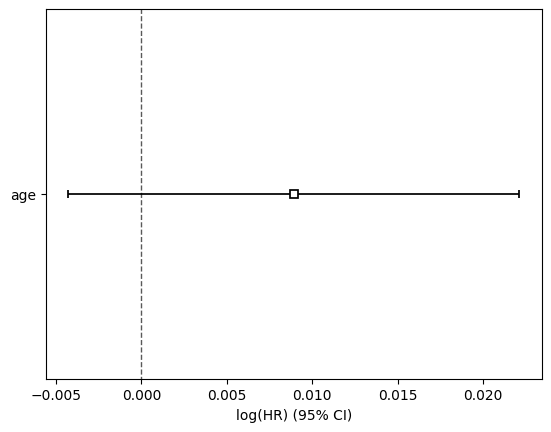

In [16]:
# Use just 'Age Date Dx Liver Cancer' for refit
age_col = 'Age Date Dx Liver Cancer'
X_age = X_nonzero_filtered[[age_col]]

# Prepare data as required by lifelines
df_lf = pd.DataFrame({
    'age': X_age[age_col].values,
    'duration': y['duration'],
    'event': y['event'].astype(int)
})

cph = CoxPHFitter()
cph.fit(df_lf, duration_col='duration', event_col='event')
cph.print_summary()  # Shows HR, 95% CI, and p-value

# You can also plot:
cph.plot()


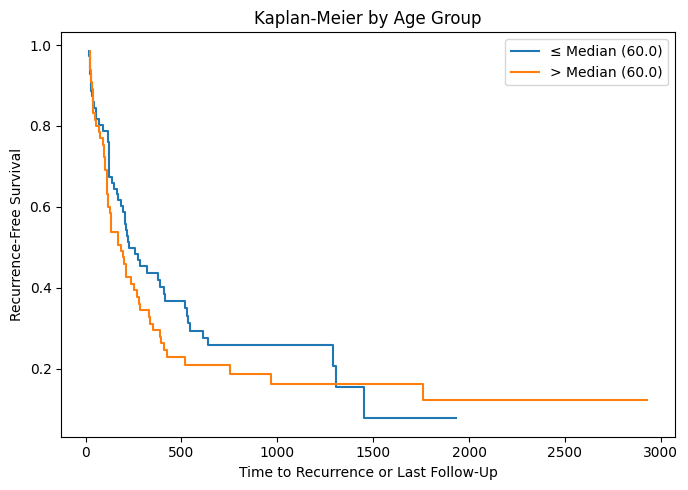

In [17]:
# Split age at median for visualization
median_age = X_age[age_col].median()
age_group = X_age[age_col] > median_age

# Plot KM curves
plt.figure(figsize=(7,5))
for group, label in zip([False, True], [f'≤ Median ({median_age:.1f})', f'> Median ({median_age:.1f})']):
    mask = (age_group == group)
    time, survival_prob = kaplan_meier_estimator(
        y[mask]['event'], y[mask]['duration']
    )
    plt.step(time, survival_prob, label=label)
plt.xlabel('Time to Recurrence or Last Follow-Up')
plt.ylabel('Recurrence-Free Survival')
plt.title('Kaplan-Meier by Age Group')
plt.legend()
plt.tight_layout()
plt.show()


Index(['95% lower-bound', '95% upper-bound'], dtype='object')


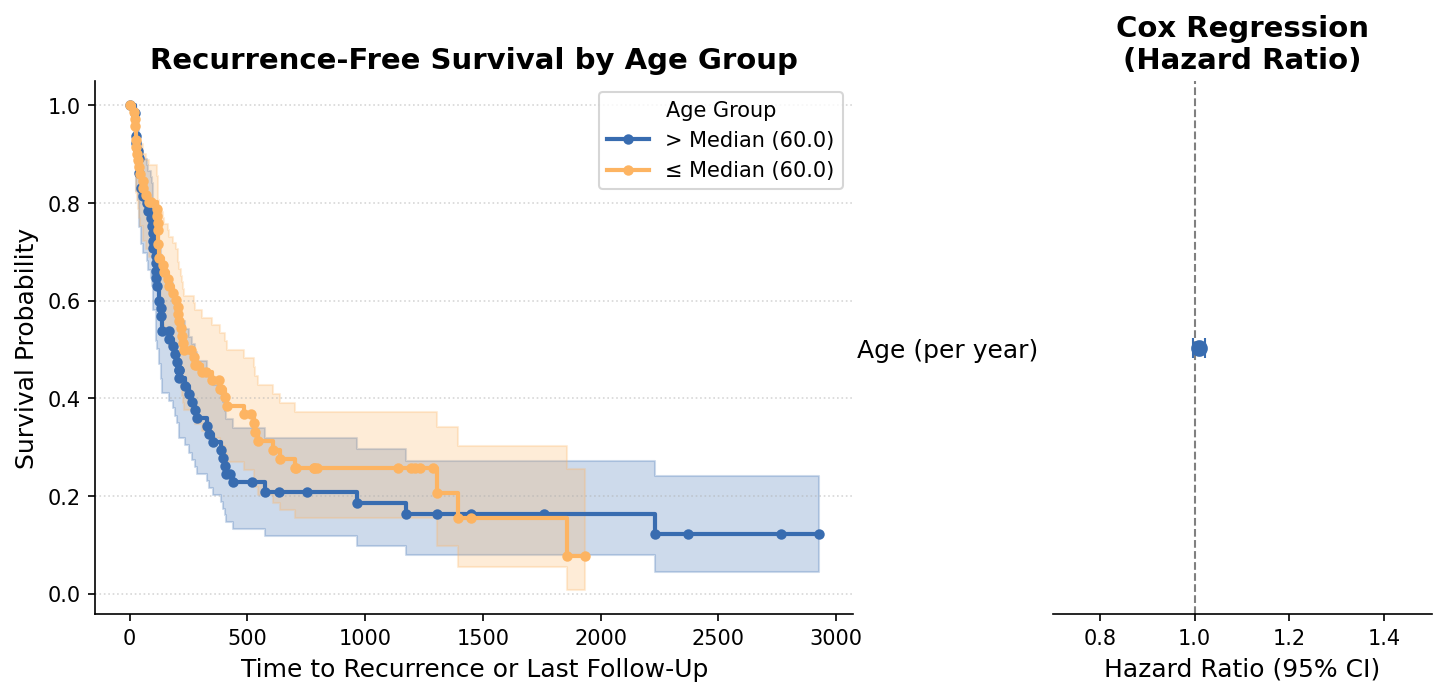

<Figure size 640x480 with 0 Axes>

In [18]:
# Prepare data for lifelines
df_lf = pd.DataFrame({
    'age': X_age[age_col].values,
    'duration': y['duration'],
    'event': y['event'].astype(int)
})

# Stratify by age (median split)
median_age = df_lf['age'].median()
df_lf['age_group'] = np.where(df_lf['age'] > median_age, f'> Median ({median_age:.1f})', f'≤ Median ({median_age:.1f})')

# Fit Cox model
cph = CoxPHFitter()
cph.fit(df_lf[['age', 'duration', 'event']], duration_col='duration', event_col='event')

# Fit KM curves
kmf = KaplanMeierFitter()

fig, axes = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [2, 1]}, dpi=150)

# --- Left: KM Curves ---
ax_km = axes[0]
colors = ['#386cb0', '#fdb462']  # blue and orange for colorblind friendliness

for i, (group, grp_df) in enumerate(df_lf.groupby('age_group')):
    kmf.fit(grp_df['duration'], grp_df['event'], label=group)
    kmf.plot(ax=ax_km, ci_show=True, color=colors[i], lw=2, marker='o', markersize=4)

ax_km.set_title('Recurrence-Free Survival by Age Group', fontsize=14, weight='bold')
ax_km.set_xlabel('Time to Recurrence or Last Follow-Up', fontsize=12)
ax_km.set_ylabel('Survival Probability', fontsize=12)
ax_km.legend(title="Age Group")
ax_km.grid(axis='y', linestyle=':', alpha=0.5)
ax_km.spines['top'].set_visible(False)
ax_km.spines['right'].set_visible(False)

# --- Right: Forest Plot ---
ax_forest = axes[1]

# After fitting model and printing columns:
print(cph.confidence_intervals_.columns)  # Debugging, see actual column names

hr = np.exp(cph.params_['age'])
ci_low = np.exp(cph.confidence_intervals_.iloc[0, 0])
ci_high = np.exp(cph.confidence_intervals_.iloc[0, 1])

# Now your plotting code follows as before


ax_forest.errorbar(hr, 0, xerr=[[hr - ci_low], [ci_high - hr]],
                   fmt='o', color='#386cb0', ecolor='#386cb0', capsize=5, lw=2, markersize=7)
ax_forest.axvline(1, color='grey', linestyle='--', lw=1)
ax_forest.set_yticks([0])
ax_forest.set_yticklabels(['Age (per year)'], fontsize=12)
ax_forest.set_xlabel('Hazard Ratio (95% CI)', fontsize=12)
ax_forest.set_xlim(left=0.7, right=max(ci_high * 1.1, 1.5))
ax_forest.set_title('Cox Regression\n(Hazard Ratio)', fontsize=14, weight='bold')
ax_forest.spines['top'].set_visible(False)
ax_forest.spines['right'].set_visible(False)
ax_forest.spines['left'].set_visible(False)
ax_forest.yaxis.set_ticks_position('none')

# Remove y grid, tidy layout
ax_forest.grid(False)
plt.tight_layout(pad=2)
fig.subplots_adjust(wspace=0.35)
plt.show()
figpath = "Secondary_Tumor_Recurrence.png"
plt.savefig(figpath, dpi=600, bbox_inches='tight')
plt.savefig("Secondary_Tumor_Recurrence.png", dpi=600, bbox_inches='tight')
!cp Secondary_Tumor_Recurrence.png "/content/drive/My Drive/Tommy Rads/"

In [19]:
df = pd.read_csv('/content/drive/MyDrive/Tommy Rads/Primary_Analysis.csv', index_col=False, encoding='latin1')

In [20]:
numeric_cols = df.select_dtypes(include=np.number).columns

# Apply the mask to only the numeric columns
df[numeric_cols] = df[numeric_cols].mask(df[numeric_cols] < 0)

print(df)

    Date Ablation    Last Name        ID #   First Name         DOB Sex  \
0      12/13/2022  BLAZEJEWSKI  8447467713      DEBORAH   8/29/1958   F   
1       12/7/2022        DANNA  8442497517       JUDITH   9/28/1953   F   
2      11/22/2022      STEVENS  8467680070       MELVIN   5/12/1950   M   
3      11/15/2022        PATEL  8466643962  JAYSHREEBEN   10/5/1954   F   
4       11/9/2022        DOLAN  1003888486          LEO   4/17/1946   M   
..            ...          ...         ...          ...         ...  ..   
146     2/19/2015    MCDERMOTT  1003416447        SUSAN    4/9/1954   F   
147     2/17/2015    SILVESTER   445847783      CELESTE   1/14/1948   F   
148     2/13/2015      MCGRATH   444725758        DIANE  10/13/1953   F   
149      2/3/2015       THOMAS  1000535590       MARSHA   4/25/1954   F   
150     1/20/2015       BAILEY     1285048         LOLA   3/23/1958   F   

      Race    Ethnicity CAT type of cancer Date Dx Different Primary  \
0    White  NotHispanic    

In [21]:
# Replace '-' with NaN
#df.replace('-', np.nan, inplace=True)

# Helper function to flag unexpected values
def flag_unexpected(series, expected_type, allowed_values=None, pattern=None):
    flagged = []
    for idx, val in series.items():
        if pd.isna(val):
            continue
        if allowed_values is not None and val not in allowed_values:
            flagged.append((idx, val))
        elif expected_type == 'numeric':
            try:
                float(str(val).replace('A','')) # '12A' becomes '12'
            except:
                flagged.append((idx, val))
        elif expected_type == 'binary':
            if str(val) not in ['0', '1']:
                flagged.append((idx, val))
        elif pattern is not None:
            if not re.match(pattern, str(val)):
                flagged.append((idx, val))
    return flagged

# Cleaning report dictionary
cleaning_report = {}

# Sex: Recode to binary Sex: Male
df['Sex'] = df['Sex'].str.strip().str.upper().replace({'MALE': 'M', 'FEMALE': 'F'})
sex_binary = df['Sex'].map({'M': 1, 'F': 0})
df['Sex: Male'] = sex_binary
cleaning_report['Sex'] = flag_unexpected(df['Sex'], 'str', allowed_values=['M', 'F'])

# Race
allowed_races = ['White', 'Black', 'Asian', 'Other', 'Unknown']
df['Race'] = df['Race'].astype(str).str.strip().str.title()
cleaning_report['Race'] = flag_unexpected(df['Race'], 'str', allowed_values=allowed_races)

# Ethnicity
allowed_ethnicities = ['Hispanic', 'Nothispanic', 'Unknown']
df['Ethnicity'] = df['Ethnicity'].astype(str).str.strip().str.title()
cleaning_report['Ethnicity'] = flag_unexpected(df['Ethnicity'], 'str', allowed_values=allowed_ethnicities)

# Type of cancer
df['CAT type of cancer'] = df['CAT type of cancer'].astype(str).str.strip().str.lower()

# Age
df['Age Date Dx Liver Cancer'] = pd.to_numeric(df['Age Date Dx Liver Cancer'], errors='coerce')
cleaning_report['Age Date Dx Liver Cancer'] = flag_unexpected(df['Age Date Dx Liver Cancer'], 'numeric')

# CAT HCV
allowed_hcv = [0, 2]
df['CAT HCV (2-SVR, 1 for chronic/present, 3 HBV 4 HAV)'] = pd.to_numeric(
    df['CAT HCV (2-SVR, 1 for chronic/present, 3 HBV 4 HAV)'], errors='coerce'
)
cleaning_report['CAT HCV'] = flag_unexpected(
    df['CAT HCV (2-SVR, 1 for chronic/present, 3 HBV 4 HAV)'], 'numeric', allowed_values=allowed_hcv)

# Define a mapping of scores to integers
score_mapping = {
    '5': 1,
    '6': 2,
    '7': 3,
    '8': 4,
    '9': 5,
    '10': 6,
    '11': 7,
    '12': 8,
    '13': 9,
    '14': 10,
    '15': 11
}

# Function to extract the relevant score from the string, while handling NaN values
def extract_score(text):
    if isinstance(text, str):  # Check if the entry is a string
        for score in score_mapping:
            if re.search(score, text):
                return score
    return None  # Return None if NaN or no match is found

# Apply the function to extract the score and then map it to the integer value
df['SCALAR CPT Score (Extracted)'] = df['SCALAR CPT Score'].apply(extract_score)
df['SCALAR CPT Score (Recode)'] = df['SCALAR CPT Score (Extracted)'].map(score_mapping)

# Binary columns
binary_cols = ['EtOH', 'NASH', 'Ascites', 'Encephalopathy', 'First AFP Elevated',
               'Unilobar (0), Bilobar (1)', 'Bx during ablation (0-no, 1-yes, 2-NGS)']
for col in binary_cols:
    allowed = ['0', '1'] if 'Bx during ablation' not in col else ['0', '1', '2']
    df[col] = df[col].astype(str).str.strip()
    df[col].replace('', np.nan, inplace=True)
    cleaning_report[col] = flag_unexpected(df[col], 'binary', allowed_values=allowed)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Scalar numeric columns
scalar_cols = ['WBC', 'Hgb', 'Plt', 'Na', 'Cr', 'Albumin', 'Tbili', 'INR', 'AFP1',
               '#tumors to ablate', 'Longest Diameter Largest lesion (mm)',
               'Sum Longest Diameters', 'PS', 'Time to recur', 'SCALAR CPT Score (Recode)', 'First ablation total energy']
for col in scalar_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    cleaning_report[col] = flag_unexpected(df[col], 'numeric')

# Segment Largest Index Lesion (integer, sometimes with an 'A' suffix)
def clean_segment(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, str) and x.endswith('A'):
        x = x[:-1]
    try:
        return int(x)
    except:
        return np.nan
df['Segment Largest Index Lesion'] = df['Segment Largest Index Lesion'].apply(clean_segment)
cleaning_report['Segment Largest Index Lesion'] = flag_unexpected(df['Segment Largest Index Lesion'], 'numeric')

/tmp/ipython-input-928826444.py:92: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace('', np.nan, inplace=True)
/tmp/ipython-input-928826444.py:92: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df

In [22]:
# Liver Treatment prior to initial ablation
treatment_map = {
    '1': 'TACE',
    '2': 'TARE',
    '3': 'EBRT',
    '4': 'Systemic Therapy',
    '5': 'Resection',
    '6': 'Combined/Other'
}
def treatment_flags(cell):
    flags = {name: 0 for name in treatment_map.values()}
    if pd.isna(cell):
        return pd.Series(flags)
    items = re.findall(r'\d', str(cell))
    for item in items:
        if item in treatment_map:
            flags[treatment_map[item]] = 1
    return pd.Series(flags)
treatments = df['CAT Liver Treatment prior to initial ablation (0-none, 1-TACE, 2-TARE, 3-EBRT, 4-Systemic Therapy, 5-resection, 6-bland embo/other)'].apply(treatment_flags)
df = pd.concat([df, treatments], axis=1)
df.drop(columns=['CAT Liver Treatment prior to initial ablation (0-none, 1-TACE, 2-TARE, 3-EBRT, 4-Systemic Therapy, 5-resection, 6-bland embo/other)'], inplace=True)

# Recur (dependent)
df['Recur (0-no, 1-yes)'] = pd.to_numeric(df['Recur (0-no, 1-yes)'], errors='coerce')
cleaning_report['Recur (0-no, 1-yes)'] = flag_unexpected(df['Recur (0-no, 1-yes)'], 'binary', allowed_values=['0', '1'])

# Gather cleaning report and summarize any flagged values
flagged_summary = {col: flagged for col, flagged in cleaning_report.items() if flagged}
flagged_summary  # Show all columns with flagged/unexpected values and what those are


{'CAT HCV': [(8, 1),
  (14, 3),
  (21, 3),
  (22, 3),
  (37, 3),
  (45, 1),
  (49, 3),
  (52, 3),
  (54, 1),
  (56, 1),
  (60, 3),
  (61, 1),
  (65, 1),
  (66, 4),
  (68, 1),
  (71, 1),
  (73, 1),
  (79, 1),
  (80, 1),
  (83, 1),
  (84, 3),
  (86, 1),
  (90, 1),
  (92, 1),
  (100, 1),
  (105, 1),
  (106, 1),
  (108, 3),
  (109, 3),
  (111, 3),
  (112, 3),
  (113, 3),
  (115, 3),
  (118, 3),
  (120, 1),
  (124, 1),
  (126, 1),
  (131, 1),
  (132, 1),
  (141, 1),
  (143, 1),
  (144, 1),
  (147, 1),
  (149, 1),
  (150, 1)],
 'EtOH': [(59, '2')],
 'Ascites': [(0, '2'), (27, '2'), (36, '2'), (83, '2'), (90, '2'), (133, '2')],
 'Encephalopathy': [(23, '2'), (83, '2')],
 'Recur (0-no, 1-yes)': [(0, 1),
  (1, 0),
  (2, 0),
  (3, 0),
  (4, 0),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 0),
  (9, 0),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 0),
  (14, 1),
  (15, 0),
  (16, 1),
  (17, 0),
  (18, 1),
  (19, 0),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 0),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 

In [23]:
# First CEA Elevated: Recode to binary integers
df['First AFP Elevated'] = df['First AFP Elevated'].replace({'1.0': 1, '0.0': 0}).astype(float)
# (Leave np.nan for missing)

# Bx during ablation: Create one-hot columns for Yes (1) and NGS (2)
df['Bx during ablation: Yes'] = (df['Bx during ablation (0-no, 1-yes, 2-NGS)'] == 1).astype(int)
df['Bx during ablation: NGS'] = (df['Bx during ablation (0-no, 1-yes, 2-NGS)'] == 2).astype(int)

df['First ablation probe: PR15'] = (df['First ablation probe'] == 'PR15').astype(int)
df['First ablation probe: PR15'] = (df['First ablation probe'] == 'PR').astype(int)
df['First ablation probe: PR20'] = (df['First ablation probe'] == 'PR20').astype(int)
df['First ablation probe: LK'] = (df['First ablation probe'] == 'LK').astype(int)
df['First ablation probe: Solaris'] = (df['First ablation probe'] == 'Solaris').astype(int)

# Show the first 10 rows of the cleaned dataframe for relevant columns
df[['First AFP Elevated', 'Bx during ablation (0-no, 1-yes, 2-NGS)',
    'Bx during ablation: Yes', 'Bx during ablation: NGS']].head(10)

,First AFP Elevated,"Bx during ablation (0-no, 1-yes, 2-NGS)",Bx during ablation: Yes,Bx during ablation: NGS
0,0.0,0,0,0
1,0.0,0,0,0
2,0.0,1,1,0
3,0.0,0,0,0
4,0.0,0,0,0
5,0.0,0,0,0
6,0.0,0,0,0
7,1.0,1,1,0
8,1.0,0,0,0
9,0.0,0,0,0


In [24]:
# Define columns
scalar_cols = [
    'Age Date Dx Liver Cancer', 'WBC', 'Hgb', 'Plt', 'Na', 'Cr', 'Albumin', 'Tbili', 'INR', 'First ablation total energy',
    'AFP1', '#tumors to ablate', 'Longest Diameter Largest lesion (mm)', 'Sum Longest Diameters', 'PS', 'SCALAR CPT Score (Recode)'
]
binary_cols = [
    'Sex: Male', 'EtOH', 'NASH', 'Ascites', 'Encephalopathy', 'First AFP Elevated',
    'Unilobar (0), Bilobar (1)', 'Bx during ablation: Yes', 'Bx during ablation: NGS', 'First ablation probe: PR15',
    'First ablation probe: PR20', 'First ablation probe: LK', 'First ablation probe: Solaris','Recur (0-no, 1-yes)',
    'TACE',	'TARE',	'EBRT',	'Systemic Therapy',	'Resection',	'Combined/Other'
]
categorical_cols = [
    'Race', 'Ethnicity', 'CAT type of cancer', 'CAT HCV (2-SVR, 1 for chronic/present, 3 HBV 4 HAV)'
]

# Check scalar columns: should be numeric or NaN
scalar_issues = {}
for col in scalar_cols:
    not_scalar = df[~df[col].isna() & ~df[col].apply(lambda x: isinstance(x, (int, float)))][col]
    if not not_scalar.empty:
        scalar_issues[col] = not_scalar.unique().tolist()

# Check binary columns: should be 0, 1, or NaN
binary_issues = {}
for col in binary_cols:
    vals = set(df[col].dropna().unique())
    if not vals.issubset({0, 1}):
        binary_issues[col] = vals - {0, 1}

# Check categorical columns: show all unique values
categorical_uniques = {col: df[col].dropna().unique().tolist() for col in categorical_cols}

(scalar_issues, binary_issues, categorical_uniques)

df.to_csv("Primary_Tumors_Cleaned.csv", index=False)
!cp Primary_Tumors_Cleaned.csv "/content/drive/My Drive/Tommy Rads/"

In [25]:
# Exclude dependent variable from imputation
impute_cols = [col for col in (scalar_cols + binary_cols) if col != 'Recur (0-no, 1-yes)']

# Prepare input for imputation
impute_df = df[impute_cols]

# MICE imputation
mice = IterativeImputer(random_state=42, sample_posterior=True, max_iter=20)
imputed_array = mice.fit_transform(impute_df)
imputed_df = pd.DataFrame(imputed_array, columns=impute_cols, index=impute_df.index)

# Restore binary columns as integer 0/1
for col in binary_cols:
    if col in imputed_df.columns:
        imputed_df[col] = imputed_df[col].round().astype(int)

# Add back categorical and dependent columns, in original order
final_df = pd.concat(
    [imputed_df, df[categorical_cols + ['CAT type of cancer', 'Recur (0-no, 1-yes)']]],
    axis=1
)

# Show head and check remaining NaNs
(final_df.head(), final_df.isna().sum())

(   Age Date Dx Liver Cancer   WBC   Hgb    Plt     Na   Cr  Albumin  Tbili  \
 0                      63.0   4.0  11.0   89.0  140.0  1.0      4.0    1.0   
 1                      68.0   6.0  13.0   93.0  138.0  1.0      3.0    2.0   
 2                      72.0   6.0  13.0  108.0  135.0  1.0      4.0    1.0   
 3                      67.0  10.0  12.0  152.0  136.0  0.0      3.0    1.0   
 4                      76.0   4.0  14.0  109.0  141.0  1.0      4.0    1.0   
 
    INR  First ablation total energy       AFP1  #tumors to ablate  \
 0  1.0                       1300.0  134.67717                2.0   
 1  1.0                        650.0    2.40000                1.0   
 2  1.0                       1850.0    4.50000                1.0   
 3  1.0                       1300.0    7.20000                1.0   
 4  1.0                        650.0    5.00000                1.0   
 
    Longest Diameter Largest lesion (mm)  Sum Longest Diameters   PS  \
 0                            

In [26]:
# Drop duplicate columns, if any (from prior concatenation)
final_df = final_df.loc[:,~final_df.columns.duplicated()]

# Define categorical columns
categorical_cols = ['Race', 'Ethnicity', 'CAT type of cancer', 'CAT HCV (2-SVR, 1 for chronic/present, 3 HBV 4 HAV)']

# One-hot encode, drop first to avoid collinearity
final_encoded = pd.get_dummies(final_df, columns=categorical_cols, drop_first=True)

# Show shape and column sample
(final_encoded.shape, final_encoded.columns.tolist()[:12])

((151, 46),
 ['Age Date Dx Liver Cancer',
  'WBC',
  'Hgb',
  'Plt',
  'Na',
  'Cr',
  'Albumin',
  'Tbili',
  'INR',
  'First ablation total energy',
  'AFP1',
  '#tumors to ablate'])

In [27]:
final_encoded.head()

,Age Date Dx Liver Cancer,WBC,Hgb,Plt,Na,Cr,Albumin,Tbili,INR,First ablation total energy,AFP1,#tumors to ablate,Longest Diameter Largest lesion (mm),Sum Longest Diameters,PS,SCALAR CPT Score (Recode),Sex: Male,EtOH,NASH,Ascites,Encephalopathy,First AFP Elevated,"Unilobar (0), Bilobar (1)",Bx during ablation: Yes,Bx during ablation: NGS,First ablation probe: PR15,First ablation probe: PR20,First ablation probe: LK,First ablation probe: Solaris,TACE,TARE,EBRT,Systemic Therapy,Resection,Combined/Other,"Recur (0-no, 1-yes)",Race_Black,Race_Other,Race_Unknown,Race_White,Ethnicity_Nothispanic,CAT type of cancer_hcc,"CAT HCV (2-SVR, 1 for chronic/present, 3 HBV 4 HAV)_1","CAT HCV (2-SVR, 1 for chronic/present, 3 HBV 4 HAV)_2","CAT HCV (2-SVR, 1 for chronic/present, 3 HBV 4 HAV)_3","CAT HCV (2-SVR, 1 for chronic/present, 3 HBV 4 HAV)_4"
0,63.0,4.0,11.0,89.0,140.0,1.0,4.0,1.0,1.0,1300.0,134.67717,2.0,26.0,48.0,1.0,1.0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,False,False,False,True,True,False,False,False,False,False
1,68.0,6.0,13.0,93.0,138.0,1.0,3.0,2.0,1.0,650.0,2.40000,1.0,30.0,30.0,1.0,5.0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,False,False,False,True,True,True,False,False,False,False
2,72.0,6.0,13.0,108.0,135.0,1.0,4.0,1.0,1.0,1850.0,4.50000,1.0,20.0,20.0,1.0,2.0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,False,False,False,True,True,True,False,False,False,False
3,67.0,10.0,12.0,152.0,136.0,0.0,3.0,1.0,1.0,1300.0,7.20000,1.0,23.0,23.0,1.0,1.0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,False,False,False,False,True,True,False,False,False,False
4,76.0,4.0,14.0,109.0,141.0,1.0,4.0,1.0,1.0,650.0,5.00000,1.0,20.0,20.0,1.0,2.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,False,True,True,True,False,False,False,False


In [28]:
final_encoded.to_csv("Primary_Tumors_Cleaned_debug.csv", index=False)
!cp Primary_Tumors_Cleaned_debug.csv "/content/drive/My Drive/Tommy Rads/"

In [29]:
# Build duration and event columns for Cox model
cox_df = final_encoded.copy()
# Use event: 1 if recurred, 0 if censored
cox_df['event'] = cox_df['Recur (0-no, 1-yes)']

# Duration: 'Time to recur' if event, else 'Days between follow up and first ablation'
# Ensure both are numeric
cox_df['Time to recur'] = pd.to_numeric(df['Time to recur'], errors='coerce')
cox_df['Days between follow up and first ablation'] = pd.to_numeric(df['Days between follow up and first ablation'], errors='coerce')

cox_df['duration'] = np.where(
    cox_df['event'] == 1,
    cox_df['Time to recur'],
    cox_df['Days between follow up and first ablation']
)

# Cap duration at 10 years (3650 days)
cox_df['duration'] = cox_df['duration'].clip(upper=3650)

# Drop any rows missing duration or event
cox_df = cox_df.dropna(subset=['duration', 'event'])

# One-hot encode categorical variables (and treatment columns if not binary already)
categorical_cols = [
    'Race', 'Ethnicity', 'type of cancer', 'CAT HCV (2-SVR, 1 for chronic/present, 3 HBV 4 HAV)',
    'TACE', 'TARE', 'EBRT', 'Systemic Therapy', 'Resection', 'Combined/Other'
]
# Only include those that exist (sometimes a treatment might not be present in this subset)
categorical_cols = [col for col in categorical_cols if col in cox_df.columns]

cox_encoded = pd.get_dummies(cox_df, columns=categorical_cols, drop_first=True)

# Drop extra time columns from predictors
for drop_col in ['Time to recur', 'Days between follow up and first ablation', 'Recur (0-no, 1-yes)']:
    if drop_col in cox_encoded.columns:
        cox_encoded = cox_encoded.drop(columns=[drop_col])

# Show ready-for-cox head and shape
cox_encoded[['duration', 'event']].head(), cox_encoded.shape


(   duration  event
 0      31.0      1
 1     203.0      0
 2     218.0      0
 3     129.0      0
 4      65.0      0,
 (148, 47))

In [30]:
# Prepare predictors (X) and outcome (y)
X = cox_encoded.drop(columns=['duration', 'event'])
y = np.array([(bool(e), d) for e, d in zip(cox_encoded['event'], cox_encoded['duration'])],
             dtype=[('event', 'bool'), ('duration', 'float')])

# Remove columns with zero variance
X = pd.DataFrame(X, columns=X.columns)  # ensure DataFrame
nonzero_var_cols = X.std(axis=0) > 0
X_nonzero = X.loc[:, nonzero_var_cols]

# Define threshold for rare variable (e.g., fewer than 10 positive cases)
min_count = 10

# Identify rare one-hot columns (dummy variables)
rare_cols = [col for col in X_nonzero.columns if (X_nonzero[col].sum() < min_count)]

print("Rare columns to drop/collapse:", rare_cols)

# Drop rare columns
X_nonzero_filtered = X_nonzero.drop(columns=rare_cols)
filtered_features = X_nonzero_filtered.columns.tolist()

# Print how many features remain
print(f"Features after dropping rare dummies: {len(filtered_features)} (dropped {len(rare_cols)})")

full_features = X_nonzero_filtered.columns.tolist()

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_nonzero_filtered)

print("Full feature count (after dropping zero-variance):", len(full_features))
print("First 5 features:", full_features[:5])

# Lasso-penalized Cox (L1 only)
model = CoxnetSurvivalAnalysis(l1_ratio=1.0, n_alphas=50, alpha_min_ratio=0.05, max_iter=5000, fit_baseline_model=True)
model.fit(X_scaled, y)

# Get predictions and coefficients for each alpha in the regularization path
scores = []
for i, alpha in enumerate(model.alphas_):
    pred = model.predict(X_scaled, alpha=alpha)
    c_index = concordance_index_censored(
        cox_encoded['event'].astype(bool),
        cox_encoded['duration'],
        pred
    )[0]
    coef = model.coef_[:, i]
    scores.append((alpha, c_index, coef))

# Select best alpha (highest C-index)
best_alpha, best_cindex, best_coef = max(scores, key=lambda t: t[1])
selected = best_coef != 0
selected_features = X_nonzero_filtered.columns[selected]
selected_coefs = best_coef[selected]

# Refit model with best alpha
final_model = CoxnetSurvivalAnalysis(l1_ratio=1.0, alphas=[best_alpha], max_iter=5000)
final_model.fit(X_scaled, y)

print("\nBest alpha (lambda):", best_alpha)
print("Best C-index:", best_cindex)
print("Selected features and coefficients (nonzero):")
for name, val in zip(selected_features, selected_coefs):
    print(f"{name:40s} {val: .3f}")

# Print zero-variance check on standardized data
print((X_scaled.std(axis=0) == 0).sum(), "columns with zero variance after scaling")

# ---- BOOTSTRAP VALIDATION ----

n_bootstraps = 200
selection_counts = np.zeros(len(full_features))
my_bootstrap_alpha = best_alpha / 10

for i in tqdm(range(n_bootstraps)):
    idx = np.random.choice(X_nonzero_filtered.shape[0], size=X_nonzero_filtered.shape[0], replace=True)
    X_boot = X_nonzero_filtered.iloc[idx, :].copy()
    y_boot = y[idx]

    # Guarantee all columns are present, in the same order, even if missing from this resample
    for col in full_features:
        if col not in X_boot:
            X_boot[col] = 0  # fill with zeros

    # Re-order columns to match full_features
    X_boot = X_boot[full_features]

    # Now standardize (do NOT re-fit, just transform)
    X_boot_scaled = scaler.transform(X_boot)

    try:
        boot_model = CoxnetSurvivalAnalysis(l1_ratio=1.0, alphas=[my_bootstrap_alpha], max_iter=5000)
        boot_model.fit(X_boot_scaled, y_boot)
        model_feats = X_boot.columns
        boot_coef = pd.Series(0.0, index=full_features)  # force float for compatibility
        for coef_val, feat in zip(boot_model.coef_[0], model_feats):
            boot_coef[feat] = coef_val
        selection_counts += (boot_coef != 0).values
        print(f"Boot {i}: selected features: {boot_coef[boot_coef != 0].index.tolist()}")
    except Exception as e:
        print(f"Bootstrap {i} failed: {e}")

selection_freq = selection_counts / n_bootstraps
selected_features_df = pd.DataFrame({
    'feature': full_features,
    'selection_freq': selection_freq
}).sort_values('selection_freq', ascending=False)

print("\nFeatures selected in at least one bootstrap:")
print(selected_features_df[selected_features_df.selection_freq > 0])


Rare columns to drop/collapse: ['First ablation probe: PR15', 'First ablation probe: PR20', 'Race_Other', 'Race_Unknown', 'CAT HCV (2-SVR, 1 for chronic/present, 3 HBV 4 HAV)_4', 'TARE_1', 'Combined/Other_1']
Features after dropping rare dummies: 36 (dropped 7)
Full feature count (after dropping zero-variance): 36
First 5 features: ['Age Date Dx Liver Cancer', 'WBC', 'Hgb', 'Plt', 'Na']

Best alpha (lambda): 0.010662481259527427
Best C-index: 0.7655334114888629
Selected features and coefficients (nonzero):
Age Date Dx Liver Cancer                  0.100
WBC                                       0.077
Hgb                                       0.181
Na                                        0.060
Cr                                       -0.287
Tbili                                    -0.032
INR                                       0.160
First ablation total energy               0.240
AFP1                                     -0.019
#tumors to ablate                         0.096
Sum Long

  2%|▏         | 4/200 [00:00<00:04, 39.41it/s]

Boot 0: selected features: ['Age Date Dx Liver Cancer']
Boot 1: selected features: ['Age Date Dx Liver Cancer']
Boot 2: selected features: ['Age Date Dx Liver Cancer']
Boot 3: selected features: ['Age Date Dx Liver Cancer']
Boot 4: selected features: ['Age Date Dx Liver Cancer']
Boot 5: selected features: ['Age Date Dx Liver Cancer']
Boot 6: selected features: ['Age Date Dx Liver Cancer']
Boot 7: selected features: ['Age Date Dx Liver Cancer']


  4%|▍         | 9/200 [00:00<00:04, 44.37it/s]

Boot 8: selected features: ['Age Date Dx Liver Cancer']
Boot 9: selected features: ['Age Date Dx Liver Cancer']


  8%|▊         | 16/200 [00:00<00:03, 53.81it/s]

Boot 10: selected features: ['Age Date Dx Liver Cancer']
Boot 11: selected features: ['Age Date Dx Liver Cancer']
Boot 12: selected features: ['Age Date Dx Liver Cancer']
Boot 13: selected features: ['Age Date Dx Liver Cancer']
Boot 14: selected features: ['Age Date Dx Liver Cancer']
Boot 15: selected features: ['Age Date Dx Liver Cancer']
Boot 16: selected features: ['Age Date Dx Liver Cancer']
Boot 17: selected features: ['Age Date Dx Liver Cancer']
Boot 18: selected features: ['Age Date Dx Liver Cancer']


 14%|█▎        | 27/200 [00:00<00:04, 40.20it/s]

Boot 19: selected features: ['Age Date Dx Liver Cancer']
Boot 20: selected features: ['Age Date Dx Liver Cancer']
Boot 21: selected features: ['Age Date Dx Liver Cancer']
Boot 22: selected features: ['Age Date Dx Liver Cancer']
Boot 23: selected features: ['Age Date Dx Liver Cancer']
Boot 24: selected features: ['Age Date Dx Liver Cancer']
Boot 25: selected features: ['Age Date Dx Liver Cancer']
Boot 26: selected features: ['Age Date Dx Liver Cancer']


 16%|█▋        | 33/200 [00:00<00:03, 45.19it/s]

Boot 27: selected features: ['Age Date Dx Liver Cancer']
Boot 28: selected features: ['Age Date Dx Liver Cancer']
Boot 29: selected features: ['Age Date Dx Liver Cancer']
Boot 30: selected features: ['Age Date Dx Liver Cancer']
Boot 31: selected features: ['Age Date Dx Liver Cancer']
Boot 32: selected features: ['Age Date Dx Liver Cancer']
Boot 33: selected features: ['Age Date Dx Liver Cancer']
Boot 34: selected features: ['Age Date Dx Liver Cancer']
Boot 35: selected features: ['Age Date Dx Liver Cancer']
Boot 36: selected features: ['Age Date Dx Liver Cancer']


 22%|██▏       | 43/200 [00:01<00:03, 40.13it/s]

Boot 37: selected features: ['Age Date Dx Liver Cancer']
Boot 38: selected features: ['Age Date Dx Liver Cancer']
Boot 39: selected features: ['Age Date Dx Liver Cancer']
Boot 40: selected features: ['Age Date Dx Liver Cancer']
Boot 41: selected features: ['Age Date Dx Liver Cancer']
Boot 42: selected features: ['Age Date Dx Liver Cancer']
Boot 43: selected features: ['Age Date Dx Liver Cancer']
Boot 44: selected features: ['Age Date Dx Liver Cancer']
Boot 45: selected features: ['Age Date Dx Liver Cancer']


 26%|██▋       | 53/200 [00:01<00:03, 38.48it/s]

Boot 46: selected features: ['Age Date Dx Liver Cancer']
Boot 47: selected features: ['Age Date Dx Liver Cancer']
Boot 48: selected features: ['Age Date Dx Liver Cancer']
Boot 49: selected features: ['Age Date Dx Liver Cancer']
Boot 50: selected features: ['Age Date Dx Liver Cancer']
Boot 51: selected features: ['Age Date Dx Liver Cancer']
Boot 52: selected features: ['Age Date Dx Liver Cancer']
Boot 53: selected features: ['Age Date Dx Liver Cancer']


/tmp/ipython-input-3761651437.py:94: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=5000).
  boot_model.fit(X_boot_scaled, y_boot)
 29%|██▉       | 58/200 [00:01<00:04, 34.84it/s]

Boot 54: selected features: ['Age Date Dx Liver Cancer']
Boot 55: selected features: ['Age Date Dx Liver Cancer']
Boot 56: selected features: ['Age Date Dx Liver Cancer']
Boot 57: selected features: ['Age Date Dx Liver Cancer']
Boot 58: selected features: ['Age Date Dx Liver Cancer']
Boot 59: selected features: ['Age Date Dx Liver Cancer']


 34%|███▎      | 67/200 [00:01<00:03, 37.58it/s]

Boot 60: selected features: ['Age Date Dx Liver Cancer']
Boot 61: selected features: ['Age Date Dx Liver Cancer']
Boot 62: selected features: ['Age Date Dx Liver Cancer']
Boot 63: selected features: ['Age Date Dx Liver Cancer']
Boot 64: selected features: []
Boot 65: selected features: ['Age Date Dx Liver Cancer']
Boot 66: selected features: ['Age Date Dx Liver Cancer']
Boot 67: selected features: ['Age Date Dx Liver Cancer']
Boot 68: selected features: ['Age Date Dx Liver Cancer']
Boot 69: selected features: ['Age Date Dx Liver Cancer']
Boot 70: selected features: ['Age Date Dx Liver Cancer']


 38%|███▊      | 77/200 [00:01<00:03, 40.79it/s]

Boot 71: selected features: ['Age Date Dx Liver Cancer']
Boot 72: selected features: ['Age Date Dx Liver Cancer']
Boot 73: selected features: ['Age Date Dx Liver Cancer']
Boot 74: selected features: ['Age Date Dx Liver Cancer']
Boot 75: selected features: ['Age Date Dx Liver Cancer']
Boot 76: selected features: ['Age Date Dx Liver Cancer']
Boot 77: selected features: ['Age Date Dx Liver Cancer']
Boot 78: selected features: ['Age Date Dx Liver Cancer']
Boot 79: selected features: ['Age Date Dx Liver Cancer']
Boot 80: selected features: ['Age Date Dx Liver Cancer']


 41%|████      | 82/200 [00:02<00:02, 41.84it/s]

Boot 81: selected features: ['Age Date Dx Liver Cancer']
Boot 82: selected features: ['Age Date Dx Liver Cancer']
Boot 83: selected features: ['Age Date Dx Liver Cancer']
Boot 84: selected features: ['Age Date Dx Liver Cancer']


 46%|████▌     | 92/200 [00:02<00:02, 36.03it/s]

Boot 85: selected features: ['Age Date Dx Liver Cancer']
Boot 86: selected features: ['Age Date Dx Liver Cancer']
Boot 87: selected features: ['Age Date Dx Liver Cancer']
Boot 88: selected features: ['Age Date Dx Liver Cancer']
Boot 89: selected features: ['Age Date Dx Liver Cancer']
Boot 90: selected features: ['Age Date Dx Liver Cancer']
Boot 91: selected features: ['Age Date Dx Liver Cancer']
Boot 92: selected features: ['Age Date Dx Liver Cancer']
Boot 93: selected features: ['Age Date Dx Liver Cancer']
Boot 94: selected features: ['Age Date Dx Liver Cancer']
Boot 95: selected features: ['Age Date Dx Liver Cancer']


/tmp/ipython-input-3761651437.py:94: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=5000).
  boot_model.fit(X_boot_scaled, y_boot)
 52%|█████▏    | 103/200 [00:02<00:02, 39.28it/s]

Boot 96: selected features: ['Age Date Dx Liver Cancer']
Boot 97: selected features: ['Age Date Dx Liver Cancer']
Boot 98: selected features: ['Age Date Dx Liver Cancer']
Boot 99: selected features: ['Age Date Dx Liver Cancer']
Boot 100: selected features: ['Age Date Dx Liver Cancer']
Boot 101: selected features: ['Age Date Dx Liver Cancer']
Boot 102: selected features: ['Age Date Dx Liver Cancer']
Boot 103: selected features: ['Age Date Dx Liver Cancer']
Boot 104: selected features: ['Age Date Dx Liver Cancer']
Boot 105: selected features: ['Age Date Dx Liver Cancer']
Boot 106: selected features: ['Age Date Dx Liver Cancer']


 57%|█████▋    | 114/200 [00:02<00:02, 40.66it/s]

Boot 107: selected features: ['Age Date Dx Liver Cancer']
Boot 108: selected features: ['Age Date Dx Liver Cancer']
Boot 109: selected features: ['Age Date Dx Liver Cancer']
Boot 110: selected features: ['Age Date Dx Liver Cancer']
Boot 111: selected features: ['Age Date Dx Liver Cancer']
Boot 112: selected features: ['Age Date Dx Liver Cancer']
Boot 113: selected features: ['Age Date Dx Liver Cancer']
Boot 114: selected features: ['Age Date Dx Liver Cancer']
Boot 115: selected features: ['Age Date Dx Liver Cancer']


 60%|█████▉    | 119/200 [00:03<00:01, 42.30it/s]

Boot 116: selected features: ['Age Date Dx Liver Cancer']
Boot 117: selected features: ['Age Date Dx Liver Cancer']
Boot 118: selected features: ['Age Date Dx Liver Cancer']
Boot 119: selected features: ['Age Date Dx Liver Cancer']
Boot 120: selected features: ['Age Date Dx Liver Cancer']
Boot 121: selected features: ['Age Date Dx Liver Cancer']


 62%|██████▏   | 124/200 [00:03<00:02, 35.12it/s]

Boot 122: selected features: ['Age Date Dx Liver Cancer']
Boot 123: selected features: ['Age Date Dx Liver Cancer']
Boot 124: selected features: ['Age Date Dx Liver Cancer']
Boot 125: selected features: ['Age Date Dx Liver Cancer']


 64%|██████▍   | 128/200 [00:03<00:02, 26.41it/s]/tmp/ipython-input-3761651437.py:94: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=5000).
  boot_model.fit(X_boot_scaled, y_boot)
 66%|██████▌   | 132/200 [00:03<00:02, 27.64it/s]

Boot 126: selected features: ['Age Date Dx Liver Cancer']
Boot 127: selected features: ['Age Date Dx Liver Cancer']
Boot 128: selected features: ['Age Date Dx Liver Cancer']
Boot 129: selected features: []
Boot 130: selected features: ['Age Date Dx Liver Cancer']
Boot 131: selected features: []


 71%|███████   | 142/200 [00:03<00:01, 35.19it/s]

Boot 132: selected features: ['Age Date Dx Liver Cancer']
Boot 133: selected features: ['Age Date Dx Liver Cancer']
Boot 134: selected features: ['Age Date Dx Liver Cancer']
Boot 135: selected features: ['Age Date Dx Liver Cancer']
Boot 136: selected features: ['Age Date Dx Liver Cancer']
Boot 137: selected features: ['Age Date Dx Liver Cancer']
Boot 138: selected features: ['Age Date Dx Liver Cancer']
Boot 139: selected features: ['Age Date Dx Liver Cancer']
Boot 140: selected features: ['Age Date Dx Liver Cancer']
Boot 141: selected features: ['Age Date Dx Liver Cancer']


 76%|███████▌  | 152/200 [00:04<00:01, 39.92it/s]

Boot 142: selected features: ['Age Date Dx Liver Cancer']
Boot 143: selected features: ['Age Date Dx Liver Cancer']
Boot 144: selected features: ['Age Date Dx Liver Cancer']
Boot 145: selected features: ['Age Date Dx Liver Cancer']
Boot 146: selected features: ['Age Date Dx Liver Cancer']
Boot 147: selected features: ['Age Date Dx Liver Cancer']
Boot 148: selected features: ['Age Date Dx Liver Cancer']
Boot 149: selected features: ['Age Date Dx Liver Cancer']
Boot 150: selected features: ['Age Date Dx Liver Cancer']
Boot 151: selected features: ['Age Date Dx Liver Cancer']


 78%|███████▊  | 157/200 [00:04<00:01, 38.27it/s]

Boot 152: selected features: ['Age Date Dx Liver Cancer']
Boot 153: selected features: ['Age Date Dx Liver Cancer']
Boot 154: selected features: ['Age Date Dx Liver Cancer']
Boot 155: selected features: ['Age Date Dx Liver Cancer']
Boot 156: selected features: ['Age Date Dx Liver Cancer']
Boot 157: selected features: ['Age Date Dx Liver Cancer']
Boot 158: selected features: ['Age Date Dx Liver Cancer']


 80%|████████  | 161/200 [00:04<00:01, 29.01it/s]

Boot 159: selected features: ['Age Date Dx Liver Cancer']
Boot 160: selected features: ['Age Date Dx Liver Cancer']
Boot 161: selected features: ['Age Date Dx Liver Cancer']


 82%|████████▎ | 165/200 [00:04<00:01, 24.69it/s]

Boot 162: selected features: ['Age Date Dx Liver Cancer']
Boot 163: selected features: ['Age Date Dx Liver Cancer']
Boot 164: selected features: ['Age Date Dx Liver Cancer']
Boot 165: selected features: ['Age Date Dx Liver Cancer']
Boot 166: selected features: ['Age Date Dx Liver Cancer']
Boot 167: selected features: ['Age Date Dx Liver Cancer']
Boot 168: selected features: ['Age Date Dx Liver Cancer']
Boot 169: selected features: ['Age Date Dx Liver Cancer']


 89%|████████▉ | 178/200 [00:04<00:00, 38.34it/s]

Boot 170: selected features: ['Age Date Dx Liver Cancer']
Boot 171: selected features: ['Age Date Dx Liver Cancer']
Boot 172: selected features: ['Age Date Dx Liver Cancer']
Boot 173: selected features: ['Age Date Dx Liver Cancer']
Boot 174: selected features: ['Age Date Dx Liver Cancer']
Boot 175: selected features: ['Age Date Dx Liver Cancer']
Boot 176: selected features: ['Age Date Dx Liver Cancer']
Boot 177: selected features: ['Age Date Dx Liver Cancer']
Boot 178: selected features: ['Age Date Dx Liver Cancer']
Boot 179: selected features: ['Age Date Dx Liver Cancer']
Boot 180: selected features: ['Age Date Dx Liver Cancer']
Boot 181: selected features: ['Age Date Dx Liver Cancer']
Boot 182: selected features: ['Age Date Dx Liver Cancer']


 95%|█████████▌| 190/200 [00:05<00:00, 44.20it/s]

Boot 183: selected features: ['Age Date Dx Liver Cancer']
Boot 184: selected features: ['Age Date Dx Liver Cancer']
Boot 185: selected features: ['Age Date Dx Liver Cancer']
Boot 186: selected features: ['Age Date Dx Liver Cancer']
Boot 187: selected features: ['Age Date Dx Liver Cancer']
Boot 188: selected features: ['Age Date Dx Liver Cancer']
Boot 189: selected features: ['Age Date Dx Liver Cancer']
Boot 190: selected features: ['Age Date Dx Liver Cancer']
Boot 191: selected features: ['Age Date Dx Liver Cancer']
Boot 192: selected features: ['Age Date Dx Liver Cancer']


100%|██████████| 200/200 [00:05<00:00, 37.32it/s]

Boot 193: selected features: ['Age Date Dx Liver Cancer']
Boot 194: selected features: ['Age Date Dx Liver Cancer']
Boot 195: selected features: ['Age Date Dx Liver Cancer']
Boot 196: selected features: ['Age Date Dx Liver Cancer']
Boot 197: selected features: ['Age Date Dx Liver Cancer']
Boot 198: selected features: ['Age Date Dx Liver Cancer']
Boot 199: selected features: ['Age Date Dx Liver Cancer']

Features selected in at least one bootstrap:
                    feature  selection_freq
0  Age Date Dx Liver Cancer           0.985


<lifelines.CoxPHFitter: fitted with 148 total observations, 48 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 148
number of events observed = 100
   partial log-likelihood = -429.08
         time fit was run = 2025-07-31 08:44:13 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age        0.01      1.01      0.01           -0.01            0.04                0.99                1.04

           cmp to    z    p  -log2(p)
covariate                            
age          0.00 1.21 0.23      2.15
---
Concordance = 0.52
Partial AIC = 860.16
log-likelihood ratio test = 1.52 on 1 df
-log2(p) of ll-ratio test = 2.20

<Axes: xlabel='log(HR) (95% CI)'>

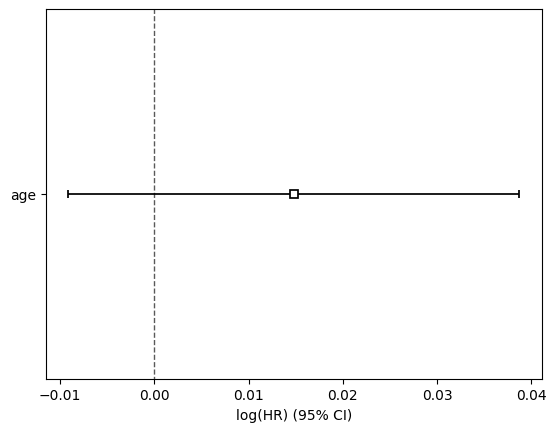

In [31]:
# Use just 'Age Date Dx Liver Cancer' for refit
age_col = 'Age Date Dx Liver Cancer'
X_age = X_nonzero_filtered[[age_col]]

# Prepare data as required by lifelines
df_lf = pd.DataFrame({
    'age': X_age[age_col].values,
    'duration': y['duration'],
    'event': y['event'].astype(int)
})

cph = CoxPHFitter()
cph.fit(df_lf, duration_col='duration', event_col='event')
cph.print_summary()  # Shows HR, 95% CI, and p-value

# You can also plot:
cph.plot()

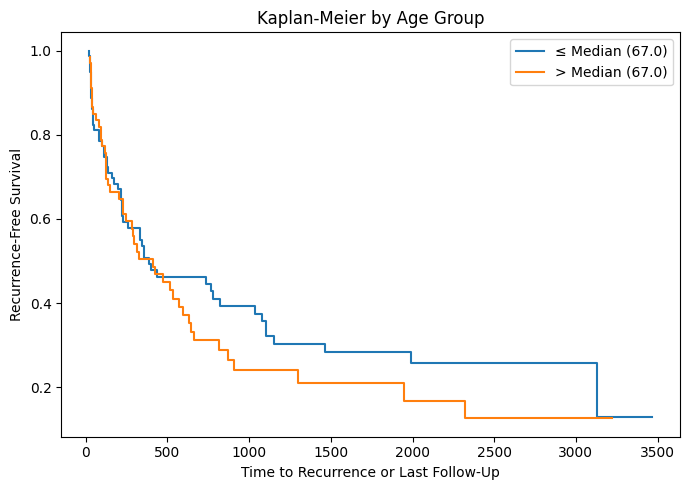

In [32]:
# Split age at median for visualization
median_age = X_age[age_col].median()
age_group = X_age[age_col] > median_age

# Plot KM curves
plt.figure(figsize=(7,5))
for group, label in zip([False, True], [f'≤ Median ({median_age:.1f})', f'> Median ({median_age:.1f})']):
    mask = (age_group == group)
    time, survival_prob = kaplan_meier_estimator(
        y[mask]['event'], y[mask]['duration']
    )
    plt.step(time, survival_prob, label=label)
plt.xlabel('Time to Recurrence or Last Follow-Up')
plt.ylabel('Recurrence-Free Survival')
plt.title('Kaplan-Meier by Age Group')
plt.legend()
plt.tight_layout()
plt.show()

Index(['95% lower-bound', '95% upper-bound'], dtype='object')


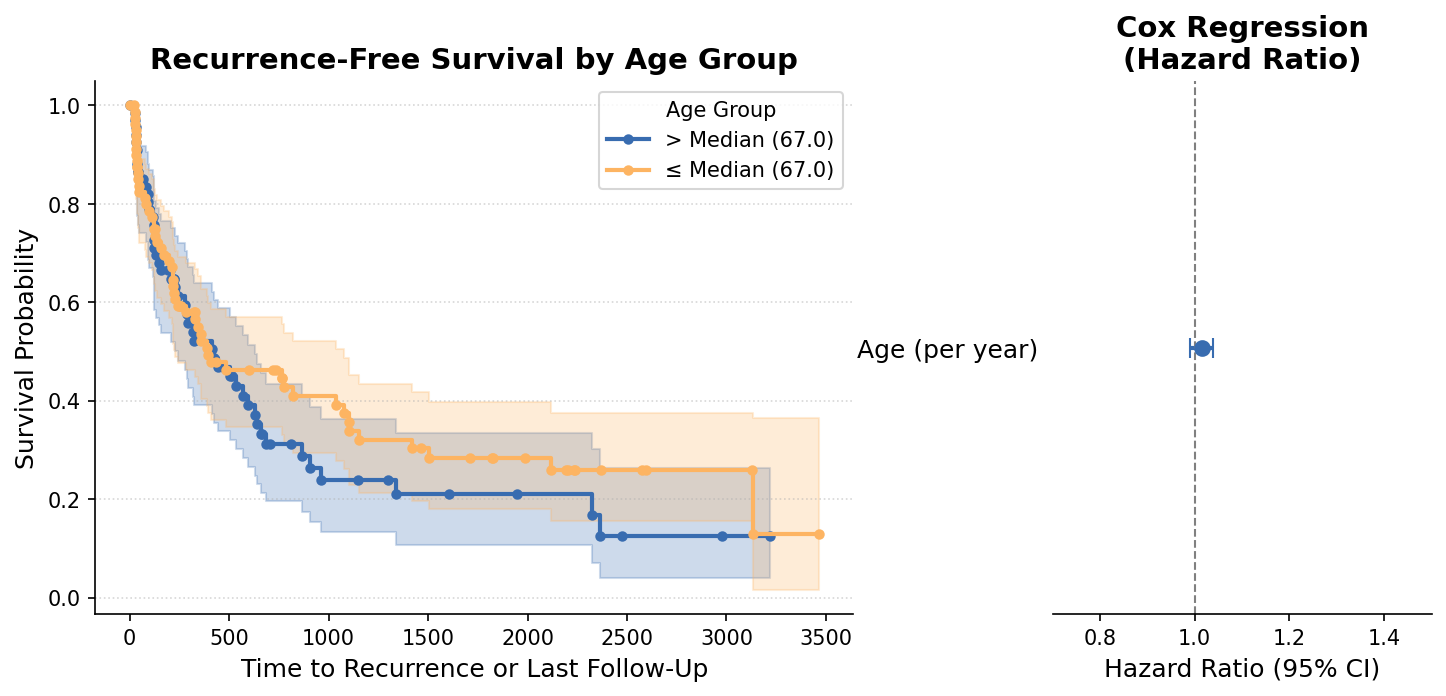

<Figure size 640x480 with 0 Axes>

In [33]:
# Prepare data for lifelines
df_lf = pd.DataFrame({
    'age': X_age[age_col].values,
    'duration': y['duration'],
    'event': y['event'].astype(int)
})

# Stratify by age (median split)
median_age = df_lf['age'].median()
df_lf['age_group'] = np.where(df_lf['age'] > median_age, f'> Median ({median_age:.1f})', f'≤ Median ({median_age:.1f})')

# Fit Cox model
cph = CoxPHFitter()
cph.fit(df_lf[['age', 'duration', 'event']], duration_col='duration', event_col='event')

# Fit KM curves
kmf = KaplanMeierFitter()

fig, axes = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [2, 1]}, dpi=150)

# --- Left: KM Curves ---
ax_km = axes[0]
colors = ['#386cb0', '#fdb462']  # blue and orange for colorblind friendliness

for i, (group, grp_df) in enumerate(df_lf.groupby('age_group')):
    kmf.fit(grp_df['duration'], grp_df['event'], label=group)
    kmf.plot(ax=ax_km, ci_show=True, color=colors[i], lw=2, marker='o', markersize=4)

ax_km.set_title('Recurrence-Free Survival by Age Group', fontsize=14, weight='bold')
ax_km.set_xlabel('Time to Recurrence or Last Follow-Up', fontsize=12)
ax_km.set_ylabel('Survival Probability', fontsize=12)
ax_km.legend(title="Age Group")
ax_km.grid(axis='y', linestyle=':', alpha=0.5)
ax_km.spines['top'].set_visible(False)
ax_km.spines['right'].set_visible(False)

# --- Right: Forest Plot ---
ax_forest = axes[1]

# After fitting model and printing columns:
print(cph.confidence_intervals_.columns)  # Debugging, see actual column names

hr = np.exp(cph.params_['age'])
ci_low = np.exp(cph.confidence_intervals_.iloc[0, 0])
ci_high = np.exp(cph.confidence_intervals_.iloc[0, 1])

# Now your plotting code follows as before


ax_forest.errorbar(hr, 0, xerr=[[hr - ci_low], [ci_high - hr]],
                   fmt='o', color='#386cb0', ecolor='#386cb0', capsize=5, lw=2, markersize=7)
ax_forest.axvline(1, color='grey', linestyle='--', lw=1)
ax_forest.set_yticks([0])
ax_forest.set_yticklabels(['Age (per year)'], fontsize=12)
ax_forest.set_xlabel('Hazard Ratio (95% CI)', fontsize=12)
ax_forest.set_xlim(left=0.7, right=max(ci_high * 1.1, 1.5))
ax_forest.set_title('Cox Regression\n(Hazard Ratio)', fontsize=14, weight='bold')
ax_forest.spines['top'].set_visible(False)
ax_forest.spines['right'].set_visible(False)
ax_forest.spines['left'].set_visible(False)
ax_forest.yaxis.set_ticks_position('none')

# Remove y grid, tidy layout
ax_forest.grid(False)
plt.tight_layout(pad=2)
fig.subplots_adjust(wspace=0.35)
plt.show()
figpath = "Primary_Tumor_Recurrence.png"
plt.savefig(figpath, dpi=600, bbox_inches='tight')
plt.savefig("Primary_Tumor_Recurrence.png", dpi=600, bbox_inches='tight')
!cp Primary_Tumor_Recurrence.png "/content/drive/My Drive/Tommy Rads/"

In [34]:
import pandas as pd
import numpy as np
import re

# Load the data (update path if needed)
df = pd.read_csv('/content/drive/MyDrive/Tommy Rads/Combined_Analysis.csv', index_col=False, encoding='latin1')

# 1. Keep only patients with recurrence
df = df[df['Recur (0-no, 1-yes)'] == 1].copy()
df = df.reset_index(drop=True)

# Drop 'Recur (0-no, 1-yes)' and 'Time to recur'
df = df.drop(columns=['Recur (0-no, 1-yes)', 'Time to recur'], errors='ignore')

df.head()


,Sex,Race,Ethnicity,CAT type of cancer,Age Date Dx Liver Cancer,"CAT HCV (2-SVR, 1 for chronic/present, 3 HBV 4 HAV)",EtOH,NASH,"Recurrence Local (0-no, 1-yes)",Recurrence EHD,Site of EHD,Treatment Recurrence,Repeat ablation probe,Repeat ablation total energy,Ascites2,Encephalopathy2,WBC2,Hgb5,Plt6,Na7,Cr8,Albumin2,Tbili2,INR11,AFP2,Unit2,CEA13,Second AFP Elevated,# tumors to ablate,Longest Diameter Largest lesion,Sum Longest Diameters15,Segment of Largest Index Lesion16,"Unilobar (0), Bilobar (1)17",BCLC2,Native Na-MELD18,SCALAR CPT2,PS2,"Bx Recurrence (0-no,1-yes,2-NGS)","Progression Local (0-no, 1-yes)",TTP after repeat treatment,Response at last liver imaging,Non-target response at last imaging,Days between follow up and first ablation,Secondary Tumor 1 yes
0,F,White,NotHispanic,cholangiocc,63,0,0,0,0.0,0.0,NaN,4.0,NaN,NaN,2.0,0.0,6.90,10.0,195.0,138.0,0.64,3.0,0.6,1.1,NaN,NaN,2.8,0.0,6.0,20.0,40.0,7,0.0,NaN,12.0,B9,0.0,0.0,NaN,NaN,SD,SD,195,0
1,M,White,NotHispanic,HCC,63,0,0,1,1.0,1.0,Lymph,4.0,NaN,NaN,1.0,1.0,7.80,13.5,93.0,137.0,1.24,3.8,1.1,1.2,3.5,IU/mL,2.2,0.0,2.0,13.0,21.0,7,0.0,A,12.0,B7,1.0,1.0,NaN,NaN,SD,SD,153,0
2,M,White,NotHispanic,HCC,63,0,0,0,0.0,0.0,NaN,0.0,PR15,650.0,0.0,1.0,4.00,11.4,103.0,134.0,1.20,2.4,0.7,1.1,1.0,ng/mL,NaN,0.0,1.0,19.0,19.0,5,0.0,A,11.0,B9,2.0,0.0,NaN,NaN,CR,NaN,323,0
3,M,Black,NotHispanic,HCC,64,2,0,0,1.0,0.0,NaN,2.0,NaN,NaN,1.0,0.0,5.60,15.2,231.0,135.0,0.71,4.0,0.6,1.1,49.0,ng/mL,NaN,1.0,1.0,12.0,12.0,1,1.0,A,7.0,A5,0.0,0.0,1.0,100.0,CR,NaN,263,0
4,F,White,NotHispanic,cholangiocc,77,0,0,0,1.0,1.0,Lung,3.0,NaN,NaN,1.0,1.0,4.54,12.4,160.0,137.0,1.00,3.8,0.6,NaN,NaN,NaN,1.4,0.0,0.0,24.0,37.0,8,0.0,NaN,NaN,NaN,1.0,0.0,1.0,138.0,PR,NaN,345,0


In [35]:
def flag_unexpected(series, dtype, allowed_values=None):
    """
    Returns a set of unique values outside the allowed set or dtype.
    """
    if allowed_values is not None:
        return set(series.dropna().unique()) - set(allowed_values)
    if dtype == 'binary':
        return set(series.dropna().unique()) - {0, 1}
    return set()

# Sex
df['Sex, Male'] = df['Sex'].map({'M': 1, 'F': 0})
sex_abnorm = flag_unexpected(df['Sex'], None, ['M', 'F'])
if sex_abnorm:
    print("Abnormal values in Sex:", sex_abnorm)

# Race to dummies
df['Race'] = df['Race'].astype('category')
race_dummies = pd.get_dummies(df['Race'], prefix='Race')
df = pd.concat([df, race_dummies], axis=1)

df['Ethnicity'] = df['Ethnicity'].replace({np.nan: 'NotHispanic'})
df['Ethnicity, Hispanic'] = df['Ethnicity'].apply(lambda x: 'Hispanic' if str(x).strip().lower() == 'hispanic' else 'NotHispanic')
ethn_abnorm = flag_unexpected(df['Ethnicity, Hispanic'], None, ['Hispanic', 'NotHispanic'])
if ethn_abnorm:
    print("Abnormal values in Ethnicity:", ethn_abnorm)
ethnicity_dummies = pd.get_dummies(df['Ethnicity, Hispanic'], prefix='Ethnicity')
df = pd.concat([df, ethnicity_dummies], axis=1)

top5_cancers = df['CAT type of cancer'].value_counts().nlargest(5).index.tolist()
df['CAT type of cancer (Top5)'] = df['CAT type of cancer'].where(df['CAT type of cancer'].isin(top5_cancers), np.nan)
cancer_dummies = pd.get_dummies(df['CAT type of cancer (Top5)'], prefix='Cancer')
df = pd.concat([df, cancer_dummies], axis=1)

df['Age Date Dx Liver Cancer'] = pd.to_numeric(df['Age Date Dx Liver Cancer'], errors='coerce')

df['CAT HCV (2-SVR, 1 for chronic/present, 3 HBV 4 HAV)'] = pd.to_numeric(df['CAT HCV (2-SVR, 1 for chronic/present, 3 HBV 4 HAV)'], errors='coerce')
hcv_dummies = pd.get_dummies(df['CAT HCV (2-SVR, 1 for chronic/present, 3 HBV 4 HAV)'], prefix='HCV')
df = pd.concat([df, hcv_dummies], axis=1)

binary_cols = ['EtOH', 'NASH', 'Second AFP Elevated']
for col in binary_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
        df[col] = df[col].where(df[col].isin([0,1]), 0).astype(int)
        abnormal = flag_unexpected(df[col], 'binary')
        if abnormal:
            print(f"Abnormal values in {col}:", abnormal)

site_lists = df['Site of EHD'].fillna('').str.lower().str.replace(r'[^a-z,\s]', '', regex=True).str.split(',')
all_sites = [site.strip() for sites in site_lists for site in sites if site.strip()]
from collections import Counter
site_counts = Counter(all_sites)
top4_sites = [s for s, _ in site_counts.most_common(4)]
for site in top4_sites:
    df[f'EHD_{site.title()}'] = site_lists.apply(lambda x: int(site in [s.strip() for s in x]))
df['EHD_Other'] = site_lists.apply(lambda x: int(any(s.strip() not in top4_sites and s.strip() != '' for s in x)))

treat_map = {0:'Ablation', 1:'TACE', 2:'TARE', 3:'EBRT', 4:'Systemic Therapy', 5:'Resection', 6:'Transplant', 7:'Combined/Other', 8:'None'}
df['Treatment Recurrence'] = pd.to_numeric(df['Treatment Recurrence'], errors='coerce').map(treat_map)
tx_dummies = pd.get_dummies(df['Treatment Recurrence'], prefix='Tx')
df = pd.concat([df, tx_dummies], axis=1)

score_mapping = {'A5': 5, 'A6': 6, 'A7': 7, 'B7': 8, 'B8': 9, 'B9': 10, 'C10': 11, 'C11': 12, 'C12': 13, 'C13': 14, 'C14': 15, 'C15': 16}
def extract_score(text):
    if isinstance(text, str):
        match = re.match(r'([ABC][0-9]+)', text)
        if match:
            return match.group(1)
    return None
df['SCALAR CPT Score 2 (Extracted)'] = df['SCALAR CPT2'].apply(extract_score)
df['SCALAR CPT Score 2 (Recode)'] = df['SCALAR CPT Score 2 (Extracted)'].map(score_mapping)

score_mapping2 = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5}
def extract_score2(text):
    if isinstance(text, str):
        for score in score_mapping2:
            if re.search(score, text):
                return score
    return None
df['BCLC2 (Extracted)'] = df['BCLC2'].apply(extract_score2)
df['BCLC2 (Recode)'] = df['BCLC2 (Extracted)'].map(score_mapping2)

scalar_cols = ['Age Date Dx Liver Cancer', 'Ascites2', 'WBC2', 'Hgb5', 'Plt6', 'Na7', 'Cr8', 'Albumin2', 'Tbili2', 'INR11',
               'CEA13', 'AFP2', '# tumors to ablate', 'Longest Diameter Largest lesion', 'Sum Longest Diameters15', 'PS2',
               'SCALAR CPT Score 2 (Recode)', 'Native Na-MELD18', 'BCLC2 (Recode)']
for col in scalar_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['Unilobar (0), Bilobar (1)17'] = pd.to_numeric(df['Unilobar (0), Bilobar (1)17'], errors='coerce').fillna(0).astype(int)

df['Bx Recurrence (0-no,1-yes,2-NGS)'] = pd.to_numeric(df['Bx Recurrence (0-no,1-yes,2-NGS)'], errors='coerce')
bx_dummies = pd.get_dummies(df['Bx Recurrence (0-no,1-yes,2-NGS)'], prefix='BxRec')
df = pd.concat([df, bx_dummies], axis=1)

to_drop = ['Repeat ablation probe', 'Repeat ablation total energy', 'Unit2', 'Time to recur']
df = df.drop(columns=[col for col in to_drop if col in df.columns], errors='ignore')

print("\nFinal df shape:", df.shape)
print("Missing values per column:\n", df.isnull().sum().sort_values(ascending=False).head(25))
print("Column sample:", df.columns[:20])


Final df shape: (208, 81)
Missing values per column:
 CEA13                                  166
BCLC2 (Extracted)                      119
BCLC2 (Recode)                         119
Site of EHD                            117
AFP2                                   116
BCLC2                                  116
INR11                                  115
SCALAR CPT Score 2 (Recode)            113
SCALAR CPT2                            113
SCALAR CPT Score 2 (Extracted)         113
Native Na-MELD18                       112
Albumin2                               112
Tbili2                                 110
Hgb5                                   108
Na7                                    108
WBC2                                   107
Plt6                                   107
Cr8                                    107
Non-target response at last imaging     82
Progression Local (0-no, 1-yes)         69
TTP after repeat treatment              62
CAT type of cancer (Top5)               28

In [36]:
# List of columns you must NOT impute (these are special: outcome, censoring, grouping, event, time)
do_not_impute = [
    'Recurrence Local (0-no, 1-yes)',
    'Recurrence EHD',
    'Progression Local (0-no, 1-yes)',
    'TTP after repeat treatment',
    'Response at last liver imaging',
    'Non-target response at last imaging',
    'Days between follow up and first ablation',
    'Secondary Tumor 1 yes'
]

# Define your predictors to impute (remove all do-not-impute columns from all columns)
possible_impute_cols = [col for col in df.columns if col not in do_not_impute]

# For categorical dummies, you may want to avoid columns that are all zero or all one:
# But if you want to be sure, just impute all non-special columns.

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Only use numeric columns for imputation
predictor_impute_cols = [col for col in possible_impute_cols if pd.api.types.is_numeric_dtype(df[col])]
impute_df = df[predictor_impute_cols].copy()

# Impute using MICE
imputer = IterativeImputer(random_state=42, max_iter=20)
imputed_array = imputer.fit_transform(impute_df)
imputed_df = pd.DataFrame(imputed_array, columns=impute_df.columns, index=impute_df.index)

# Round binary cols again if needed (add any additional binary dummies you want to enforce as 0/1)
binary_cols_final = [col for col in binary_cols if col in imputed_df.columns]
for col in binary_cols_final:
    imputed_df[col] = imputed_df[col].round().astype(int)

# Check for any NaNs left (should be zero)
print("Imputed DataFrame NaNs:", imputed_df.isnull().sum().sum())

# Attach back all do-not-impute columns (no imputation performed, as requested)
final_cols = imputed_df.copy()
for col in do_not_impute:
    if col in df.columns:
        final_cols[col] = df[col].copy()  # attach as-is

# Show summary
print("Final analysis DataFrame shape:", final_cols.shape)
print("Any remaining NaNs (should only be in do-not-impute columns):")
print(final_cols[do_not_impute].isnull().sum())

for col in final_cols.columns:
    if final_cols[col].isnull().all():
        print(f"Column {col} is ALL NaN.")
    elif (final_cols[col] == 0).all():
        print(f"Column {col} is ALL ZERO.")

Imputed DataFrame NaNs: 0
Final analysis DataFrame shape: (208, 68)
Any remaining NaNs (should only be in do-not-impute columns):
Recurrence Local (0-no, 1-yes)                0
Recurrence EHD                                1
Progression Local (0-no, 1-yes)              69
TTP after repeat treatment                   62
Response at last liver imaging                0
Non-target response at last imaging          82
Days between follow up and first ablation     0
Secondary Tumor 1 yes                         0
dtype: int64


In [39]:
# Grouping logic: These columns must not have been imputed!
is_primary   = final_cols['Secondary Tumor 1 yes'] == 0
is_secondary = final_cols['Secondary Tumor 1 yes'] == 1

# Local progression
has_local    = final_cols['Recurrence Local (0-no, 1-yes)'] == 1

# Distant progression (use any EHD and at least one site flagged)
has_distant  = final_cols['Recurrence EHD'] == 1

# Build masks
masks = {
    'all_primary': is_primary,
    'all_secondary': is_secondary,
    'local_primary': is_primary & has_local,
    'local_secondary': is_secondary & has_local,
    'distant_primary': is_primary & has_distant,
    'distant_secondary': is_secondary & has_distant,
}

# Columns to drop (the "do-not-impute" columns, outcomes/time/event/censoring)
predictor_cols = [col for col in final_cols.columns if col not in do_not_impute]

clean_subsets = {}
for name, mask in masks.items():
    print(f"{name}: {mask.sum()} rows selected")

for name, mask in masks.items():
    subset = final_cols.loc[mask, predictor_cols].copy()
    # Drop any residual NaNs just in case (shouldn't exist after imputation)
    subset = subset.dropna(axis=0, how='any')
    clean_subsets[name] = subset
    print(f"{name}: shape={subset.shape}, NaNs remaining? {subset.isnull().sum().sum()}")
    #print("Subsets created:", list(full_subsets.keys()))

for col in ['Secondary Tumor 1 yes', 'Recurrence Local (0-no, 1-yes)', 'Recurrence EHD']:
    if col in final_cols:
        print(f"{col} unique values: {final_cols[col].unique()}")
    else:
        print(f"{col} NOT FOUND in final_cols!")


event_time_cols = [col for col in do_not_impute if col in final_cols.columns]
full_subsets = {}
for name, mask in masks.items():
    subset = final_cols.loc[mask, predictor_cols + event_time_cols].copy()
    # You can drop rows with missing event/time columns at modeling time
    full_subsets[name] = subset
    print(f"{name}: shape={subset.shape}")
print("Subsets created:", list(full_subsets.keys()))

print("final_cols shape:", final_cols.shape)
print("final_cols columns:", final_cols.columns.tolist())


print(clean_subsets['all_primary'].head())


all_primary: 102 rows selected
all_secondary: 106 rows selected
local_primary: 58 rows selected
local_secondary: 53 rows selected
distant_primary: 20 rows selected
distant_secondary: 70 rows selected
all_primary: shape=(102, 60), NaNs remaining? 0
all_secondary: shape=(106, 60), NaNs remaining? 0
local_primary: shape=(58, 60), NaNs remaining? 0
local_secondary: shape=(53, 60), NaNs remaining? 0
distant_primary: shape=(20, 60), NaNs remaining? 0
distant_secondary: shape=(70, 60), NaNs remaining? 0
Secondary Tumor 1 yes unique values: [0 1]
Recurrence Local (0-no, 1-yes) unique values: [0. 1.]
Recurrence EHD unique values: [ 0.  1. nan]
all_primary: shape=(102, 68)
all_secondary: shape=(106, 68)
local_primary: shape=(58, 68)
local_secondary: shape=(53, 68)
distant_primary: shape=(20, 68)
distant_secondary: shape=(70, 68)
Subsets created: ['all_primary', 'all_secondary', 'local_primary', 'local_secondary', 'distant_primary', 'distant_secondary']
final_cols shape: (208, 68)
final_cols colu

In [41]:
# (Assume full_subsets['all_primary'] exists)
df = full_subsets['all_primary'].copy()

# Example: Ablation vs. All Others
df['TreatmentGroup'] = (df['Tx_Ablation'] == 1).astype(int)

# Covariates for propensity score model (no treatment/outcome columns)
ps_covariates = [col for col in predictor_cols if not col.startswith('Tx_')]

from sklearn.linear_model import LogisticRegression

ps_model = LogisticRegression(max_iter=10000)
ps_model.fit(df[ps_covariates], df['TreatmentGroup'])
df['propensity_score'] = ps_model.predict_proba(df[ps_covariates])[:, 1]

from sklearn.neighbors import NearestNeighbors

treated = df[df['TreatmentGroup'] == 1]
control = df[df['TreatmentGroup'] == 0]

nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])

matched_control = control.iloc[indices.flatten()]
matched_df = pd.concat([treated, matched_control], axis=0)
matched_df = matched_df.sample(frac=1, random_state=42)  # Shuffle


In [42]:
matched_subsets = {}
for key in full_subsets:
    # ...matching code...
    matched_subsets[key] = matched_df

In [70]:
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import KFold
from concurrent.futures import ThreadPoolExecutor, as_completed

from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import KFold
from concurrent.futures import ThreadPoolExecutor, as_completed
import numpy as np
import pandas as pd

def lasso_cox_trydrop_bootstrap(df, pred_cols, outcome_time, outcome_event,
                                max_iter=15, n_boot=200, top_n=5, min_n=6, verbose=True):
    X = df[pred_cols].apply(pd.to_numeric, errors='coerce')
    y_time = df[outcome_time]
    y_event = df[outcome_event]
    X = X.loc[:, X.notnull().any(axis=0)]
    good_idx = X.notnull().all(axis=1) & y_time.notnull() & y_event.notnull()
    X = X.loc[good_idx].reset_index(drop=True)
    y_time = y_time.loc[good_idx].reset_index(drop=True)
    y_event = y_event.loc[good_idx].reset_index(drop=True)
    n_samples = X.shape[0]
    if n_samples < min_n:
        if verbose:
            print(f"    Skipping: not enough samples after filtering.")
        return None

    y = Surv.from_arrays(event=y_event.astype(bool), time=y_time)
    dropped = []

    for attempt in range(max_iter):
        try:
            # Alpha search
            alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100, 1000]
            kf = KFold(n_splits=5, shuffle=True, random_state=42)
            best_alpha = alphas[0]
            best_cindex = -1
            for alpha in alphas:
                cindex = []
                for train_idx, test_idx in kf.split(X):
                    model = CoxnetSurvivalAnalysis(l1_ratio=1.0, alphas=[alpha], max_iter=50000)
                    model.fit(X.iloc[train_idx], y[train_idx])
                    pred = model.predict(X.iloc[test_idx])
                    if np.sum(y[train_idx]['event']) == 0 or np.sum(y[test_idx]['event']) == 0:
                        continue  # No events in this split
                    ci = concordance_index_censored(y[test_idx]['event'], y[test_idx]['time'], pred)[0]
                    cindex.append(ci)
                mean_ci = np.mean(cindex) if len(cindex) else np.nan
                if mean_ci > best_cindex:
                    best_cindex = mean_ci
                    best_alpha = alpha

            model = CoxnetSurvivalAnalysis(l1_ratio=1.0, alphas=[best_alpha], max_iter=10000)
            model.fit(X, y)
            coefs = model.coef_
            if coefs.ndim > 1:
                coefs = coefs[:, 0]
            feature_names = X.columns
            coef_table = pd.DataFrame({'feature': feature_names, 'coef': coefs})
            coef_table = coef_table[coef_table['coef'] != 0].copy()
            if coef_table.empty and X.shape[1] > 1:
                # No signal found, drop lowest variance col and retry
                variances = X.var().sort_values()
                col_to_drop = variances.index[0]
                if verbose:
                    print(f"    All zero coefs, dropping {col_to_drop}")
                X = X.drop(columns=[col_to_drop])
                dropped.append(col_to_drop)
                continue
            # Success! Bootstrap top N features
            coef_table['abs_coef'] = coef_table['coef'].abs()
            coef_table['hazard_ratio'] = np.exp(coef_table['coef'])
            coef_table['best_alpha'] = best_alpha
            coef_table['c_index'] = best_cindex
            top_feats = coef_table.nlargest(top_n, 'abs_coef')['feature'].tolist()
            if verbose:
                print(f"    Bootstrapping CIs for: {top_feats}")
            lower_ci, upper_ci = {}, {}
            def bootstrap_hr_ci(X, y, feature_name, alpha, n_boot=200,
                                alpha_fallbacks=[0.01, 0.1, 1.0, 10, 100]):
                n = X.shape[0]
                coefs = []
                for _ in range(n_boot):
                    idx = np.random.choice(n, n, replace=True)
                    if not np.any(y[idx]['event']):
                        coefs.append(np.nan)
                        continue
                    for trial_alpha in [alpha] + alpha_fallbacks:
                        try:
                            model = CoxnetSurvivalAnalysis(l1_ratio=1.0, alphas=[trial_alpha], max_iter=20000)
                            model.fit(X.iloc[idx], y[idx])
                            coef_vec = model.coef_[:, 0]
                            features = X.columns
                            coef_dict = dict(zip(features, coef_vec))
                            coefs.append(coef_dict.get(feature_name, 0.0))
                            break
                        except ArithmeticError:
                            continue
                    else:
                        coefs.append(np.nan)
                coefs = np.array(coefs)
                hr_boot = np.exp(coefs)
                hr_boot = hr_boot[~np.isnan(hr_boot)]
                if len(hr_boot) == 0:
                    return np.nan, np.nan
                return np.percentile(hr_boot, 2.5), np.percentile(hr_boot, 97.5)

            with ThreadPoolExecutor(max_workers=min(8, len(top_feats))) as executor:
                futures = {
                    executor.submit(bootstrap_hr_ci, X, y, feat, best_alpha, n_boot): feat
                    for feat in top_feats
                }
                for future in as_completed(futures):
                    feat = futures[future]
                    l, u = future.result()
                    lower_ci[feat] = l
                    upper_ci[feat] = u
            coef_table['hr_CI_lower'] = coef_table['feature'].map(lower_ci)
            coef_table['hr_CI_upper'] = coef_table['feature'].map(upper_ci)
            coef_table['dropped'] = ','.join(dropped)
            return coef_table
        except Exception as e:
            if verbose:
                print(f"    Model failed ({e}), dropping rarest and retrying.")
            if X.shape[1] <= 1:
                if verbose:
                    print("    Only one predictor left, giving up.")
                return None
            variances = X.var().sort_values()
            col_to_drop = variances.index[0]
            X = X.drop(columns=[col_to_drop])
            dropped.append(col_to_drop)
    print("    Max iterations exceeded.")
    return None


# Main loop
subset_labels = {
    'local_primary': 'Local Primary',
    'local_secondary': 'Local Secondary',
    'distant_primary': 'Distant Primary',
    'distant_secondary': 'Distant Secondary',
    'all_primary': 'All Primary',
    'all_secondary': 'All Secondary'
}

all_results = []
for key, df in matched_subsets.items():
    print(f"\n=== Coxnet Try-and-Drop+Bootstrap: {subset_labels[key]} ===")
    # Build duration/event if not present
    if 'duration' not in df or 'event' not in df:
        df['Progression Local (0-no, 1-yes)'] = df['Progression Local (0-no, 1-yes)'].fillna(0).astype(int)
        df['duration'] = df.apply(
            lambda row: row['TTP after repeat treatment'] if row['Progression Local (0-no, 1-yes)'] == 1
            else row['Days between follow up and first ablation'], axis=1
        )
    df['event'] = df['Progression Local (0-no, 1-yes)']
    pred_cols = [col for col in impute_cols if col in df.columns]
    res = lasso_cox_trydrop_bootstrap(df, pred_cols, outcome_time='duration', outcome_event='event',
                                      max_iter=15, n_boot=200, top_n=5, min_n=6, verbose=True)
    if res is not None:
        res['subset'] = subset_labels[key]
        all_results.append(res)

if all_results:
    all_results_cox = pd.concat(all_results, ignore_index=True)
    print(all_results_cox.head())
    all_results_cox.to_csv("cox_lasso_allsubsets_trydrop_bootstrap.csv", index=False)
else:
    print("No converged Coxnet models for any group.")

!cp cox_lasso_allsubsets_trydrop_bootstrap.csv "/content/drive/My Drive/Tommy Rads/"




=== Coxnet Try-and-Drop+Bootstrap: All Primary ===
    Bootstrapping CIs for: ['EtOH', 'Age Date Dx Liver Cancer']


/tmp/ipython-input-3234548668.py:45: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X.iloc[train_idx], y[train_idx])
/tmp/ipython-input-3234548668.py:45: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X.iloc[train_idx], y[train_idx])
/tmp/ipython-input-3234548668.py:45: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X.iloc[train_idx], y[train_idx])
/tmp/ipython-input-3234548668.py:45: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X.iloc[train_idx], y[train_idx])
/tmp/ipython-input-3234548668.py:45: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X.iloc[train_idx], y[train_idx])
/tmp/ipython-input-3234548668.py:45: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X.iloc[train_idx], y[train_idx])
/tmp/ipython-input-3234548668.py:45: UserWarning: all coefficients are zero, consider decreasing alpha.
  


=== Coxnet Try-and-Drop+Bootstrap: All Secondary ===
    Bootstrapping CIs for: ['EtOH', 'Age Date Dx Liver Cancer']


/tmp/ipython-input-3234548668.py:94: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=20000).
  model.fit(X.iloc[idx], y[idx])
/tmp/ipython-input-3234548668.py:105: RuntimeWarning: overflow encountered in exp
  hr_boot = np.exp(coefs)
/tmp/ipython-input-3234548668.py:45: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X.iloc[train_idx], y[train_idx])
/tmp/ipython-input-3234548668.py:45: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X.iloc[train_idx], y[train_idx])
/tmp/ipython-input-3234548668.py:45: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X.iloc[train_idx], y[train_idx])
/tmp/ipython-input-3234548668.py:45: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X.iloc[train_idx], y[train_idx])
/tmp/ipython-input-3234548668.py:45: UserWarning: all coefficients are zero, consider decreasing alpha.
 


=== Coxnet Try-and-Drop+Bootstrap: Local Primary ===
    Bootstrapping CIs for: ['EtOH', 'Age Date Dx Liver Cancer']

=== Coxnet Try-and-Drop+Bootstrap: Local Secondary ===
    Bootstrapping CIs for: ['EtOH', 'Age Date Dx Liver Cancer']


/tmp/ipython-input-3234548668.py:45: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X.iloc[train_idx], y[train_idx])
/tmp/ipython-input-3234548668.py:45: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X.iloc[train_idx], y[train_idx])
/tmp/ipython-input-3234548668.py:45: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X.iloc[train_idx], y[train_idx])
/tmp/ipython-input-3234548668.py:45: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X.iloc[train_idx], y[train_idx])
/tmp/ipython-input-3234548668.py:45: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X.iloc[train_idx], y[train_idx])
/tmp/ipython-input-3234548668.py:45: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X.iloc[train_idx], y[train_idx])
/tmp/ipython-input-3234548668.py:45: UserWarning: all coefficients are zero, consider decreasing alpha.
  


=== Coxnet Try-and-Drop+Bootstrap: Distant Primary ===
    Bootstrapping CIs for: ['EtOH', 'Age Date Dx Liver Cancer']


/tmp/ipython-input-3234548668.py:94: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=20000).
  model.fit(X.iloc[idx], y[idx])
/tmp/ipython-input-3234548668.py:94: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=20000).
  model.fit(X.iloc[idx], y[idx])



=== Coxnet Try-and-Drop+Bootstrap: Distant Secondary ===
    Bootstrapping CIs for: ['EtOH', 'Age Date Dx Liver Cancer']


/tmp/ipython-input-3234548668.py:45: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X.iloc[train_idx], y[train_idx])
/tmp/ipython-input-3234548668.py:45: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X.iloc[train_idx], y[train_idx])
/tmp/ipython-input-3234548668.py:45: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X.iloc[train_idx], y[train_idx])
/tmp/ipython-input-3234548668.py:45: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X.iloc[train_idx], y[train_idx])
/tmp/ipython-input-3234548668.py:45: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X.iloc[train_idx], y[train_idx])
/tmp/ipython-input-3234548668.py:45: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X.iloc[train_idx], y[train_idx])
/tmp/ipython-input-3234548668.py:45: UserWarning: all coefficients are zero, consider decreasing alpha.
  

                    feature      coef  abs_coef  hazard_ratio  best_alpha  \
0  Age Date Dx Liver Cancer  0.108301  0.108301      1.114383       0.001   
1                      EtOH -1.137410  1.137410      0.320648       0.001   
2  Age Date Dx Liver Cancer  0.108301  0.108301      1.114383       0.001   
3                      EtOH -1.137410  1.137410      0.320648       0.001   
4  Age Date Dx Liver Cancer  0.108301  0.108301      1.114383       0.001   

    c_index  hr_CI_lower  hr_CI_upper dropped         subset  
0  0.744048     1.024011     1.756155            All Primary  
1  0.744048     0.005880     1.757555            All Primary  
2  0.744048     1.026242     1.575342          All Secondary  
3  0.744048     0.007316     1.845353          All Secondary  
4  0.744048     1.024642     1.462526          Local Primary  


In [64]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import StratifiedKFold
from concurrent.futures import ThreadPoolExecutor, as_completed

# Define favorable/unfavorable mapping for Outcome A
def outcome_A(target):
    # Favorable = CR or PR; Unfavorable = SD or PD
    favorable = ['CR', 'PR']
    return target.isin(favorable).astype(int)

# Define CR vs all (Outcome B)
def outcome_B(target):
    return (target == 'CR').astype(int)

# Helper: get top N features by abs(coef)
def get_top_features(model, X, n=5):
    coefs = model.coef_.flatten()
    abs_coefs = np.abs(coefs)
    top_idx = np.argsort(abs_coefs)[::-1][:n]
    return X.columns[top_idx].tolist()

def bootstrap_or_ci(X, y, feature, C, n_boot=200):
    n = X.shape[0]
    coefs = []
    for _ in range(n_boot):
        idx = np.random.choice(n, n, replace=True)
        X_boot = X.iloc[idx]
        y_boot = y.iloc[idx]
        try:
            model = LogisticRegression(C=C, penalty="l1", solver="saga", max_iter=5000)
            model.fit(X_boot, y_boot)
            coef = model.coef_.flatten()
            features = X.columns
            coef_dict = dict(zip(features, coef))
            coefs.append(coef_dict.get(feature, 0.0))
        except Exception:
            coefs.append(np.nan)
    coefs = np.array(coefs)
    or_boot = np.exp(coefs[~np.isnan(coefs)])
    if len(or_boot) == 0:
        return np.nan, np.nan
    return np.percentile(or_boot, 2.5), np.percentile(or_boot, 97.5)



In [65]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from concurrent.futures import ThreadPoolExecutor, as_completed

def run_lasso_trydrop_boot(df, outcome_fn, min_n=6, max_iter=20, n_boot=200):
    # Save outcome column BEFORE dummy coding
    if 'Response at last liver imaging' not in df.columns:
        print("  Skipped (no outcome column).")
        return None

    outcome_col = df['Response at last liver imaging'].astype(str).copy()
    df = pd.get_dummies(df, columns=['Response at last liver imaging'], prefix='Imaging', dummy_na=False)

    pred_cols = [col for col in impute_cols if col in df.columns]
    pred_cols += [col for col in df.columns if col.startswith('Imaging_')]
    pred_cols = [col for col in pred_cols if not col.startswith('Imaging_')]
    X = df[pred_cols].apply(pd.to_numeric, errors='coerce')
    X = X.loc[:, X.notnull().any(axis=0)]
    good_idx = X.notnull().all(axis=1)
    X = X.loc[good_idx].reset_index(drop=True)
    outcome_col = outcome_col.loc[good_idx].reset_index(drop=True)

    n_samples = X.shape[0]
    if n_samples < min_n:
        print(f"  Skipped (n={n_samples})—not enough data.")
        return None

    y = outcome_fn(outcome_col)
    if y.sum() == 0 or y.sum() == n_samples:
        print(f"  Skipped (no variation in outcome).")
        return None

    dropped = []
    for attempt in range(max_iter):
        try:
            clf = LogisticRegressionCV(Cs=10, cv=StratifiedKFold(5, shuffle=True, random_state=42),
                                      penalty='l1', solver='saga', max_iter=5000, scoring='roc_auc', n_jobs=-1)
            clf.fit(X, y)
            best_C = clf.C_[0]
            coef = clf.coef_.flatten()
            features = X.columns
            if np.sum(coef != 0) == 0 and X.shape[1] > 1:
                variances = X.var().sort_values()
                col_to_drop = variances.index[0]
                print(f"    No nonzero features, dropping {col_to_drop}")
                X = X.drop(columns=[col_to_drop])
                dropped.append(col_to_drop)
                continue
            ORs = np.exp(coef)
            result = pd.DataFrame({
                'feature': features,
                'coef': coef,
                'OR': ORs
            })
            result = result[result['coef'] != 0].copy()
            # Bootstrapping for CIs (parallel)
            top_feats = result['feature'].tolist()
            print(f"    Bootstrapping CIs for: {top_feats}")
            ci_l, ci_u = {}, {}
            with ThreadPoolExecutor(max_workers=min(8, len(top_feats))) as executor:
                futures = {
                    executor.submit(bootstrap_or_ci, X, y, feat, best_C, n_boot): feat
                    for feat in top_feats
                }
                for future in as_completed(futures):
                    feat = futures[future]
                    l, u = future.result()
                    ci_l[feat] = l
                    ci_u[feat] = u
            result['OR_CI_lower'] = result['feature'].map(ci_l)
            result['OR_CI_upper'] = result['feature'].map(ci_u)
            result['dropped'] = ','.join(dropped)
            return result
        except Exception as e:
            if X.shape[1] <= 1:
                print("    Only one predictor left, giving up.")
                return None
            variances = X.var().sort_values()
            col_to_drop = variances.index[0]
            print(f"    Model failed ({e}), dropping {col_to_drop}")
            X = X.drop(columns=[col_to_drop])
            dropped.append(col_to_drop)
    print("    Max iterations exceeded.")
    return None

results_binA, results_binB = [], []
for key, df in matched_subsets.items():
    print(f"\n--- Binary Lasso+Bootstrap for: {subset_labels[key]} ---")
    # Outcome A
    resA = run_lasso_trydrop_boot(df.copy(), outcome_A)
    if resA is not None:
        resA['subset'] = subset_labels[key]
        resA['outcome'] = 'Favorable (CR/PR) vs Unfavorable (SD/PD)'
        results_binA.append(resA)
    # Outcome B
    resB = run_lasso_trydrop_boot(df.copy(), outcome_B)
    if resB is not None:
        resB['subset'] = subset_labels[key]
        resB['outcome'] = 'CR vs All Others'
        results_binB.append(resB)

all_results_binA = pd.concat(results_binA, ignore_index=True)
all_results_binB = pd.concat(results_binB, ignore_index=True)
all_results_binA.to_csv("lasso_logit_binaryA_allsubsets_trydrop_bootstrap.csv", index=False)
all_results_binB.to_csv("lasso_logit_binaryB_allsubsets_trydrop_bootstrap.csv", index=False)
print("\nBinary Outcome A, preview:\n", all_results_binA.head())
print("\nBinary Outcome B, preview:\n", all_results_binB.head())




--- Binary Lasso+Bootstrap for: All Primary ---


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


    Bootstrapping CIs for: ['Age Date Dx Liver Cancer', 'EtOH', 'NASH']


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

    Bootstrapping CIs for: ['Age Date Dx Liver Cancer', 'EtOH', 'NASH']


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 


--- Binary Lasso+Bootstrap for: All Secondary ---


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


    No nonzero features, dropping NASH


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


    Bootstrapping CIs for: ['Age Date Dx Liver Cancer', 'EtOH']


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

    Bootstrapping CIs for: ['Age Date Dx Liver Cancer', 'EtOH', 'NASH']


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 


--- Binary Lasso+Bootstrap for: Local Primary ---


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


    No nonzero features, dropping NASH
    No nonzero features, dropping EtOH


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


    Bootstrapping CIs for: ['Age Date Dx Liver Cancer']


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


    Bootstrapping CIs for: ['Age Date Dx Liver Cancer', 'EtOH', 'NASH']


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 


--- Binary Lasso+Bootstrap for: Local Secondary ---


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


    Bootstrapping CIs for: ['Age Date Dx Liver Cancer', 'EtOH', 'NASH']


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

    Bootstrapping CIs for: ['Age Date Dx Liver Cancer', 'EtOH', 'NASH']


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 


--- Binary Lasso+Bootstrap for: Distant Primary ---


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


    No nonzero features, dropping NASH
    Bootstrapping CIs for: ['Age Date Dx Liver Cancer', 'EtOH']


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

    Bootstrapping CIs for: ['Age Date Dx Liver Cancer', 'EtOH', 'NASH']


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 


--- Binary Lasso+Bootstrap for: Distant Secondary ---


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


    No nonzero features, dropping NASH


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


    Bootstrapping CIs for: ['Age Date Dx Liver Cancer', 'EtOH']


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

    Bootstrapping CIs for: ['Age Date Dx Liver Cancer', 'EtOH', 'NASH']


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 


Binary Outcome A, preview:
                     feature      coef        OR  OR_CI_lower  OR_CI_upper  \
0  Age Date Dx Liver Cancer  0.014707  1.014816     1.012473     1.040511   
1                      EtOH -0.619663  0.538126     0.115506     1.303715   
2                      NASH -0.293998  0.745278     0.159066     1.553680   
3  Age Date Dx Liver Cancer  0.012987  1.013072     1.008474     1.040894   
4                      EtOH -0.641167  0.526677     0.159117     1.366895   

  dropped         subset                                   outcome  
0            All Primary  Favorable (CR/PR) vs Unfavorable (SD/PD)  
1            All Primary  Favorable (CR/PR) vs Unfavorable (SD/PD)  
2            All Primary  Favorable (CR/PR) vs Unfavorable (SD/PD)  
3    NASH  All Secondary  Favorable (CR/PR) vs Unfavorable (SD/PD)  
4    NASH  All Secondary  Favorable (CR/PR) vs Unfavorable (SD/PD)  

Binary Outcome B, preview:
                     feature      coef        OR  OR_CI_lower  OR_

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [52]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(X, thresh=5.0, verbose=True):
    X_numeric = X.select_dtypes(include=[np.number]).copy()
    # Remove constant columns
    X_numeric = X_numeric.loc[:, X_numeric.std() > 0]
    dropped = []
    while True:
        vifs = pd.Series([variance_inflation_factor(X_numeric.values, i)
                          for i in range(X_numeric.shape[1])],
                         index=X_numeric.columns)
        max_vif = vifs.max()
        if max_vif > thresh:
            drop_col = vifs.idxmax()
            if verbose:
                print(f"Dropping {drop_col} with VIF={max_vif:.1f}")
            X_numeric = X_numeric.drop(columns=drop_col)
            dropped.append(drop_col)
        else:
            break
    if verbose and dropped:
        print("Final kept columns:", X_numeric.columns.tolist())
    return X_numeric.columns.tolist()


In [55]:
# Example: Outcome A = Favorable response (CR/PR) vs. Unfavorable (SD/PD)
matched_df['Favorable'] = matched_df['Response at last liver imaging'].isin(['CR', 'PR']).astype(int)

# Drop columns with <5 positive samples or <5 negative samples
def drop_sparse_cols(df, min_n=8):
    to_keep = []
    for col in df.columns:
        vals = df[col].dropna()
        n_ones = (vals == 1).sum()
        n_zeros = (vals == 0).sum()
        if min(n_ones, n_zeros) >= min_n or df[col].nunique() > 2:
            to_keep.append(col)
    return to_keep

# Only run on X (predictor matrix)
vif_cols = compute_vif(matched_df[ps_covariates], verbose=False)
X = matched_df[vif_cols + ['TreatmentGroup']]
X = X[drop_sparse_cols(X, min_n=5)]

import statsmodels.api as sm

X = sm.add_constant(X)  # Adds intercept
model = sm.Logit(y, X)
result = model.fit()

print(result.summary())

summary_df = pd.DataFrame({
    'Variable': result.params.index,
    'OR': np.exp(result.params),
    'Lower CI': np.exp(result.conf_int()[0]),
    'Upper CI': np.exp(result.conf_int()[1]),
    'p-value': result.pvalues
})
print(summary_df)


Optimization terminated successfully.
         Current function value: 0.443156
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              Favorable   No. Observations:                   48
Model:                          Logit   Df Residuals:                       39
Method:                           MLE   Df Model:                            8
Date:                Thu, 31 Jul 2025   Pseudo R-squ.:                  0.1767
Time:                        14:28:34   Log-Likelihood:                -21.271
converged:                       True   LL-Null:                       -25.837
Covariance Type:            nonrobust   LLR p-value:                    0.3314
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.4503      1.981      1.237      0.216      -1.432       6.333
En

In [62]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

def drop_sparse_cols(df, min_n=8):
    to_keep = []
    for col in df.columns:
        vals = df[col].dropna()
        n_ones = (vals == 1).sum()
        n_zeros = (vals == 0).sum()
        # Keep if enough support in both classes or is continuous (>2 unique)
        if min(n_ones, n_zeros) >= min_n or df[col].nunique() > 2:
            to_keep.append(col)
    return to_keep

results_multivar = {}

for key, matched_df in matched_subsets.items():
    print(f"\n----- Multivariate regression for {key} -----")
    matched_df = matched_df.copy()
    matched_df['Favorable'] = matched_df['Response at last liver imaging'].isin(['CR', 'PR']).astype(int)
    y = matched_df['Favorable']

    # Get predictors: VIF + TreatmentGroup, drop sparse
    vif_cols = compute_vif(matched_df[ps_covariates], verbose=False)
    pred_cols = vif_cols + ['TreatmentGroup']
    X = matched_df[pred_cols]
    X = X[drop_sparse_cols(X, min_n=8)]
    dropped = []

    if X.shape[1] < 2:
        print(f"  Skipping {key}: Not enough predictors after initial sparsity filtering.")
        continue

    while True:
        try:
            X2 = sm.add_constant(X)
            model = sm.Logit(y, X2)
            result = model.fit(disp=0)
            # Check for all-inf or all-zero ORs
            ors = np.exp(result.params)
            if np.isinf(ors).any() or (ors == 0).any():
                raise Exception("Infinite or zero ORs detected")
            # Success!
            summary_df = pd.DataFrame({
                'Variable': result.params.index,
                'OR': ors,
                'Lower CI': np.exp(result.conf_int()[0]),
                'Upper CI': np.exp(result.conf_int()[1]),
                'p-value': result.pvalues
            })
            print("Final predictors:", X.columns.tolist())
            print(summary_df)
            results_multivar[key] = summary_df
            break
        except Exception as e:
            print(f"  Model failed (reason: {e}), dropping rarest predictor and retrying...")
            # Drop rarest predictor (lowest total support, not 'const')
            support = {col: X[col].sum() for col in X.columns if col != 'const'}
            if not support:
                print("  No predictors left to drop. Skipping this group.")
                break
            rarest = min(support, key=lambda k: min(support[k], X.shape[0] - support[k]))
            print(f"    Dropping rarest: {rarest}")
            X = X.drop(columns=[rarest])
            dropped.append(rarest)
            if X.shape[1] < 2:  # Only intercept left
                print("  Only intercept left. Skipping this group.")
                break

# Optionally, export results
with pd.ExcelWriter("multivar_logit_all_groups_trydrop.xlsx") as writer:
    for group, df in results_multivar.items():
        df.to_excel(writer, sheet_name=group)



----- Multivariate regression for all_primary -----
Final predictors: ['Encephalopathy2', 'Cr8', 'Tbili2', 'AFP2', 'Second AFP Elevated', 'TreatmentGroup']
                                Variable         OR  Lower CI     Upper CI  \
const                              const  45.648750  0.763229  2730.253361   
Encephalopathy2          Encephalopathy2   1.323620  0.118840    14.742202   
Cr8                                  Cr8   1.299398  0.389046     4.339934   
Tbili2                            Tbili2   0.255899  0.010612     6.170702   
AFP2                                AFP2   1.000187  0.999396     1.000979   
Second AFP Elevated  Second AFP Elevated   0.102554  0.015875     0.662506   
TreatmentGroup            TreatmentGroup   0.401984  0.056654     2.852230   

                      p-value  
const                0.067172  
Encephalopathy2      0.819660  
Cr8                  0.670363  
Tbili2               0.401289  
AFP2                 0.642557  
Second AFP Elevated  0.016

In [72]:
import pandas as pd
import numpy as np

# Load/rename columns as needed
coxs = all_results_cox.copy()
coxs['effect_type'] = 'HR'
coxs['effect'] = coxs['hazard_ratio']
coxs['lower'] = coxs['hr_CI_lower']
coxs['upper'] = coxs['hr_CI_upper']
coxs['analysis'] = 'Coxnet'

lassoA = all_results_binA.copy()
lassoA['effect_type'] = 'OR'
lassoA['effect'] = lassoA['OR']
lassoA['lower'] = lassoA['OR_CI_lower']
lassoA['upper'] = lassoA['OR_CI_upper']
lassoA['analysis'] = 'Binary Lasso A'

lassoB = all_results_binB.copy()
lassoB['effect_type'] = 'OR'
lassoB['effect'] = lassoB['OR']
lassoB['lower'] = lassoB['OR_CI_lower']
lassoB['upper'] = lassoB['OR_CI_upper']
lassoB['analysis'] = 'Binary Lasso B'

multivar = pd.concat(results_multivar.values(), ignore_index=True)
multivar['effect_type'] = 'OR'
multivar['effect'] = multivar['OR']
multivar['lower'] = multivar['Lower CI']
multivar['upper'] = multivar['Upper CI']
multivar['analysis'] = 'Multivar Logit'

# Combine all results
combo = pd.concat([coxs, lassoA, lassoB, multivar], sort=False, ignore_index=True)
combo = combo.dropna(subset=['effect', 'lower', 'upper'])  # Drop rows missing estimates

# Use log scale for X, keeping directionality
combo['log_effect'] = np.log(combo['effect'])
combo['log_lower'] = np.log(combo['lower'])
combo['log_upper'] = np.log(combo['upper'])
combo['feature_display'] = combo['feature'] + ' (' + combo['subset'].astype(str) + ')'

combo.head()

,feature,coef,abs_coef,hazard_ratio,best_alpha,c_index,hr_CI_lower,hr_CI_upper,dropped,subset,effect_type,effect,lower,upper,analysis,OR,OR_CI_lower,OR_CI_upper,outcome,Variable,Lower CI,Upper CI,p-value,log_effect,log_lower,log_upper,feature_display
0,Age Date Dx Liver Cancer,0.108301,0.108301,1.114383,0.001,0.744048,1.024011,1.756155,,All Primary,HR,1.114383,1.024011,1.756155,Coxnet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.108301,0.023727,0.563127,Age Date Dx Liver Cancer (All Primary)
1,EtOH,-1.137410,1.137410,0.320648,0.001,0.744048,0.005880,1.757555,,All Primary,HR,0.320648,0.005880,1.757555,Coxnet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.137410,-5.136282,0.563924,EtOH (All Primary)
2,Age Date Dx Liver Cancer,0.108301,0.108301,1.114383,0.001,0.744048,1.026242,1.575342,,All Secondary,HR,1.114383,1.026242,1.575342,Coxnet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.108301,0.025904,0.454472,Age Date Dx Liver Cancer (All Secondary)
3,EtOH,-1.137410,1.137410,0.320648,0.001,0.744048,0.007316,1.845353,,All Secondary,HR,0.320648,0.007316,1.845353,Coxnet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.137410,-4.917748,0.612671,EtOH (All Secondary)
4,Age Date Dx Liver Cancer,0.108301,0.108301,1.114383,0.001,0.744048,1.024642,1.462526,,Local Primary,HR,1.114383,1.024642,1.462526,Coxnet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.108301,0.024343,0.380165,Age Date Dx Liver Cancer (Local Primary)


In [74]:
import plotly.express as px

# Choose symbols for each analysis
analysis_symbols = {
    'Coxnet': 'diamond',
    'Binary Lasso A': 'circle',
    'Binary Lasso B': 'triangle-up',
    'Multivar Logit': 'square'
}
combo['symbol'] = combo['analysis'].map(analysis_symbols)

import plotly.express as px
import numpy as np

# Clean up: Ensure log columns are all numeric (sometimes merge/csv can create 'object' dtype)
for col in ['log_effect', 'log_lower', 'log_upper']:
    combo[col] = pd.to_numeric(combo[col], errors='coerce')

# Compute CI widths (all in log space)
combo['error_x'] = combo['log_upper'] - combo['log_effect']
combo['error_x_minus'] = combo['log_effect'] - combo['log_lower']

# Now create the plot
fig = px.scatter(
    combo,
    x="log_effect",
    y="feature_display",
    color="subset",
    symbol="analysis",
    error_x="error_x",
    error_x_minus="error_x_minus",
    hover_data={
        "effect": True, "lower": True, "upper": True,
        "p-value": True, "analysis": True, "subset": True
    },
    title="Predictors of Radiologic Outcomes: Combined Analyses"
)

fig.update_traces(marker=dict(size=13, line=dict(width=1, color='black')))
fig.update_layout(
    xaxis_title="log(OR/HR)",
    yaxis_title="Predictor (subgroup)",
    legend_title="Dataset/Analysis",
    hoverlabel=dict(bgcolor="white", font_size=14, font_family="Arial"),
    height=1000,
    template="plotly_white"
)
fig.show()

